## This Project predicts the glucose level by using 5 different models(Feedforward, LSTM, CNN, CNN+LSTM, BiDirectional LSTM) and predicting for 5 different time intervals(10,20,30,40,60 minutes, more intervals can be checked as well.)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import TimeDistributed

import math
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import style

import time
#np.random.seed(8)
#tf.random.set_seed(8)

from keras.utils.vis_utils import plot_model



In [2]:
###Loading data#####
tr_glucose=np.loadtxt("../data/CGM/glucose_readings_train.csv", delimiter=',')
te_glucose=np.loadtxt("../data/CGM/glucose_readings_test.csv", delimiter=',')
te_insulin=np.loadtxt("../data/CGM/insulin_therapy_test.csv", delimiter=',')
te_carbs=np.loadtxt("../data/CGM/meals_carbs_test.csv", delimiter=',')
tr_insulin=np.loadtxt("../data/CGM/insulin_therapy_train.csv", delimiter=',')
tr_carbs=np.loadtxt("../data/CGM/meals_carbs_train.csv", delimiter=',')

In [3]:
tr_glucoseo=np.loadtxt("../data/CGM/glucose_readings_train.csv", delimiter=',')
tr_insulino=np.loadtxt("../data/CGM/insulin_therapy_train.csv", delimiter=',')
tr_carbso=np.loadtxt("../data/CGM/meals_carbs_train.csv", delimiter=',')

te_glucoseo=np.loadtxt("../data/CGM/glucose_readings_test.csv", delimiter=',')
te_insulino=np.loadtxt("../data/CGM/insulin_therapy_test.csv", delimiter=',')
te_carbso=np.loadtxt("../data/CGM/meals_carbs_test.csv", delimiter=',')

In [4]:
#####Individually scaling all the three variables as per the advice#####
forscaleg=[]
forscalec=[]
forscalei=[]

for i in range(len(tr_glucose)):
    for j in range(len(tr_glucose[i])):
        forscaleg.append(tr_glucose[i][j])
        forscalec.append(tr_carbs[i][j])
        forscalei.append(tr_insulin[i][j])

In [5]:
scg = MinMaxScaler()
scc = MinMaxScaler()
sci= MinMaxScaler()
    
scg.fit(np.array(forscaleg).reshape(-1, 1))
sci.fit(np.array(forscalei).reshape(-1, 1))
scc.fit(np.array(forscalec).reshape(-1, 1))



MinMaxScaler()

In [6]:
#####Getting the real Glucose values#####
def yplot(time_horizon):
    yplot=np.zeros((len(te_glucoseo)*(144-int(time_horizon/10))))
    x=0
    for i in range(len(te_glucoseo)):
        
        av=0
        for j in range(time_horizon,len(te_glucoseo[i]),10):
            
            yplot[x]=te_glucoseo[i][j]
            #print("ih",i,j,te_glucoseo[i][j],yplot[x],x)
            x+=1
    return yplot


In [7]:
####To avoid column/time dependency manually transforming each data element instead of transforming as 144 columns####
def scaling():
 

    
    for i in range(len(tr_glucose)):
        for j in range(len(tr_glucose[i])):
            tr_glucose[i][j]=scg.transform(np.array(tr_glucose[i][j]).reshape(-1, 1))
            tr_insulin[i][j]=sci.transform(np.array(tr_insulin[i][j]).reshape(-1, 1))
            tr_carbs[i][j]=scc.transform(np.array(tr_carbs[i][j]).reshape(-1, 1))
    for i in range(len(te_glucose)):
        for j in range(len(te_glucose[i])):
                te_glucose[i][j]=scg.transform(np.array(te_glucose[i][j]).reshape(-1, 1))
                te_insulin[i][j]=sci.transform(np.array(te_insulin[i][j]).reshape(-1, 1))
                te_carbs[i][j]=scc.transform(np.array(te_carbs[i][j]).reshape(-1, 1))

In [8]:
scaling()


In [9]:
####Combining data to have the dimensions 756*3*1440####
com_data=[]
com_data=(list(np.array([tr_glucose[i,:],tr_carbs[i,:],tr_insulin[i,:]]) for i in range(tr_glucose.shape[0])))
com_data=np.array(com_data)
print((com_data[0]))


[[0.20074386 0.22555043 0.2117358  ... 0.30086199 0.32618091 0.32508978]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.43894194 0.43894194 0.43894194 ... 0.26421884 0.26421884 0.26421884]]


In [10]:
print((com_data.shape))

(756, 3, 1440)


In [11]:
com_test_data=[]
com_test_data=(list(np.array([te_glucose[i,:],te_carbs[i,:],te_insulin[i,:]]) for i in range(te_glucose.shape[0])))
com_test_data=np.array(com_test_data)


In [12]:

####Processing data based on time horizon####
def dataproc(time_horizon):
    xtrain=np.zeros((len(com_data),(144-int(time_horizon/10)),3))
    for i in range(len(com_data)):
        z=0
        for k in range(0,1440-time_horizon,10):
            for j in range(3):
                
                
            #print("z",z,k,i)
                xtrain[i][z][j]=com_data[i][j][k]
            z+=1
    y=np.zeros((len(tr_glucose),144-int(time_horizon/10)))
    for i in range(len(tr_glucose)):
        x=0
        for j in range(time_horizon,len(tr_glucose[i]),10):
            y[i][x]=tr_glucose[i][j]
            x+=1
    #y[i][141]=y[i][142]=y[i][143]=tr_glucose[i][1439]
    test_data=np.zeros((len(com_test_data),144-int(time_horizon/10),3))

    for i in range(len(com_test_data)):
        z=0
        for k in range(0,(1440-time_horizon),10):
            for j in range(3):
                #print("z",z,k,i)
                test_data[i][z][j]=com_test_data[i][j][k]
            z+=1
    return xtrain,y,test_data



In [19]:
x,y,z=mansplitff(10)
print(x[0][0],x[0][1])

(756, 141, 3, 20)
here (756, 141, 3, 20) (324, 141, 3, 20)
[[0.20074386 0.22555043 0.2117358  0.21839642 0.22648975 0.21609082
  0.23183153 0.21001845 0.21863837 0.23329744 0.23449293 0.21775598
  0.22873842 0.2344787  0.24244868 0.23952161 0.21024142 0.22474394
  0.22156069 0.225095  ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.43894194 0.43894194 0.43894194 0.43894194 0.43894194 0.43894194
  0.43894194 0.43894194 0.43894194 0.43894194 0.27194554 0.27194554
  0.27194554 0.27194554 0.27194554 0.27194554 0.27194554 0.27194554
  0.27194554 0.27194554]] [[0.23449293 0.21775598 0.22873842 0.2344787  0.24244868 0.23952161
  0.21024142 0.22474394 0.22156069 0.225095   0.24759122 0.24067441
  0.24360148 0.2145585  0.23460679 0.23659929 0.24618224 0.22493845
  0.22870521 0.24191735]
 [0.         0.         0.         0.         0.

In [15]:
####Manually splitting data in batches for ff nw####
def mansplitff(time_horizon):  
    data,yt,test=dataproc(time_horizon)
        
    data=np.array(list(np.array([tr_glucose[i,:],tr_carbs[i,:],tr_insulin[i,:]]) for i in range(tr_glucoseo.shape[0])))
    xtrain = np.zeros((tr_glucoseo.shape[0],(144-int(time_horizon/10))-2,3,20))
    test=np.array(list(np.array([te_glucose[i,:],te_carbs[i,:],te_insulin[i,:]]) for i in range(te_glucoseo.shape[0])))
    y = np.zeros((tr_glucoseo.shape[0],(144-int(time_horizon/10)-2),1))
    test_data = np.zeros((te_glucoseo.shape[0],(144-int(time_horizon/10)-2),3,20))
    print(xtrain.shape)
    def working(time_horizon):
        for i in range(len(tr_glucoseo)):
            x=0
            h=0    
            sim=0
            for j in range(0,len(tr_glucose[i])-time_horizon-20,10):
                #print("data",data[i,:,j:j+25])
                
                xtrain[i,h,]=data[i,:,j:j+20]
                h+=1
            for amr in range(time_horizon,len(tr_glucose[i])-20,10):
                y[i,sim]=data[i,0,amr]
                sim+=1
                #print("Sim",sim)
                #test_data[i,:,]=test[i,:,j:j+10:1]
        for i in range(len(te_glucoseo)):
            x=0
                
            for j in range(0,len(te_glucose[i])-time_horizon-20,10):
                test_data[i,x,]=test[i,:,j:j+20]
                x+=1
       
        return xtrain,y,test_data
    xtrain,y,test_data=working(time_horizon)
    print("here",np.array(xtrain).shape,np.array(test_data).shape)
    return xtrain,y,test_data


In [15]:
####Manually splitting data in batches for ff and cnn nw####
def mansplit(time_horizon):  
    data,yt,test=dataproc(time_horizon)
        
    data=np.array(list(np.array([tr_glucose[i,:],tr_carbs[i,:],tr_insulin[i,:]]) for i in range(tr_glucoseo.shape[0])))
    xtrain = np.zeros((tr_glucoseo.shape[0],(144-int(time_horizon/10)-1),3,10))
    test=np.array(list(np.array([te_glucose[i,:],te_carbs[i,:],te_insulin[i,:]]) for i in range(te_glucoseo.shape[0])))
    y = np.zeros((tr_glucoseo.shape[0],(144-int(time_horizon/10)-1),1))
    test_data = np.zeros((te_glucoseo.shape[0],(144-int(time_horizon/10)-1),3,10))
    print(np.array(xtrain[0,:,0,]).shape)
    def working(time_horizon):
        for i in range(len(tr_glucoseo)):
            x=0
            h=0    
            sim=0
            for j in range(0,len(tr_glucose[i])-time_horizon-10,10):
                #print("data",data[:,:,j:j+10:1])
                xtrain[i,h,]=data[i,:,j:j+10]
                h+=1
            for amr in range(time_horizon,len(tr_glucose[i])-10,10):
                y[i,sim]=data[i,0,amr]
                sim+=1
                #print("Sim",sim)
                #test_data[i,:,]=test[i,:,j:j+10:1]
        for i in range(len(te_glucoseo)):
            x=0
                
            for j in range(0,len(te_glucose[i])-time_horizon-10,10):
                test_data[i,x,]=test[i,:,j:j+10]
                x+=1
       
        return xtrain,y,test_data
    xtrain,y,test_data=working(time_horizon)
    print(np.array(xtrain).shape,np.array(test_data).shape)
    return xtrain,y,test_data


In [16]:
'''data,yt,test=dataproc30()
    
data=np.array(list(np.array([tr_glucoseo[i,:],tr_carbso[i,:],tr_insulino[i,:]]) for i in range(tr_glucoseo.shape[0])))
xtrain = np.zeros((np.array(data).shape[0], 10, np.array(data).shape[1], 141))
test=np.array(list(np.array([te_glucoseo[i,:],te_carbso[i,:],te_insulino[i,:]]) for i in range(te_glucoseo.shape[0])))
y = np.zeros((756*141))
test_data = np.zeros((np.array(test).shape[0], 10, np.array(test).shape[1], 141))
def mansplit():
    for i in range(10):
            xtrain[:,i,]=data[:,:,0:1410:10]
            #y[:,i]=tr_glucoseo[:,30:1440:10]
            test_data[:,i,:]=test[:,:,0:1410:10]
    x=0
    for i in range(len(tr_glucoseo)):
        for j in range(30,len(tr_glucose[i]),10):
            y[x]=tr_glucoseo[i][j]
            x+=1
            #print("aaval",xtrain,y,test_data)
    return xtrain,y,test_data
xtrain,y,test_data=mansplit()
print(xtrain.shape,y.shape,test_data.shape)
'''

'data,yt,test=dataproc30()\n    \ndata=np.array(list(np.array([tr_glucoseo[i,:],tr_carbso[i,:],tr_insulino[i,:]]) for i in range(tr_glucoseo.shape[0])))\nxtrain = np.zeros((np.array(data).shape[0], 10, np.array(data).shape[1], 141))\ntest=np.array(list(np.array([te_glucoseo[i,:],te_carbso[i,:],te_insulino[i,:]]) for i in range(te_glucoseo.shape[0])))\ny = np.zeros((756*141))\ntest_data = np.zeros((np.array(test).shape[0], 10, np.array(test).shape[1], 141))\ndef mansplit():\n    for i in range(10):\n            xtrain[:,i,]=data[:,:,0:1410:10]\n            #y[:,i]=tr_glucoseo[:,30:1440:10]\n            test_data[:,i,:]=test[:,:,0:1410:10]\n    x=0\n    for i in range(len(tr_glucoseo)):\n        for j in range(30,len(tr_glucose[i]),10):\n            y[x]=tr_glucoseo[i][j]\n            x+=1\n            #print("aaval",xtrain,y,test_data)\n    return xtrain,y,test_data\nxtrain,y,test_data=mansplit()\nprint(xtrain.shape,y.shape,test_data.shape)\n'

In [17]:
# Baseline model
def feedfwd():
    regressor2 = Sequential()
    regressor2.add(Dense(units = 32))
    regressor2.add(Dense(units = 32))

    regressor2.add(Dense(units = 32))
    regressor2.add(Dense(units = 32))

    regressor2.add(Dense(units = 32))

    #regressor2.add(LeakyReLU(alpha=0.5))
    #regressor2.add(Dense(units = 32))
    #regressor2.add(Dense(units = 8))

    regressor2.add(Dense(units = 32,activation='sigmoid'))
    regressor2.add(Dense(units = 1,activation='linear'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    regressor2.compile(optimizer = opt,  loss='mean_squared_error',metrics=["RootMeanSquaredError"])

    #regressor2.fit(np.array(X), np.array(y), epochs = 2, batch_size = 8)
    return regressor2

In [18]:
def model1_ff(time_horizon):
    final_predictions_ff=[]
    #if half==True:
    xtrain,y,test_data=mansplitff(time_horizon)
    #else:
        #xtrain,y,test_data=mansplit60()
    def feedforwardNN(xtrain,y,test_data):
        feedfwdm=feedfwd()
        
        xtrain=np.reshape(xtrain, (xtrain.shape[0]* xtrain.shape[1], xtrain.shape[2],xtrain.shape[3] ))
        y=np.reshape(y, (y.shape[0]* y.shape[1], y.shape[2] ))
        test_data=np.reshape(test_data, (test_data.shape[0]* test_data.shape[1], test_data.shape[2],test_data.shape[3] ))
        print("shape",xtrain.shape,y.shape)
        xval=xtrain[-30000:]
        yval=y[-30000:]
        xtrain=xtrain[:30000]
        y=y[:30000]
        #print(xval[0],"phoch",xtrain[0],"aage",y[0])
       
        history=feedfwdm.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        #print(feedfwdm.summary())
        name='ff'+str(time_horizon)
        pl=name+'.png'
        plot_model(feedfwdm,to_file=pl, show_shapes=True, show_layer_names=True)
        #font = ImageFont.truetype("arial.ttf",12)
        #print("adfm dakfm dcc dsds",feedfwdm)
        #visualkeras.layered_view(feedfwdm)
        #ann_viz(feedfwdm, title="My first neural network")

        fin_feedfwd=feedfwdm.predict(test_data)
        print("importa",np.array(fin_feedfwd).shape)
        for i in range(len(fin_feedfwd)):
           # for j in range(len(fin_feedfwd[i])):
                final_predictions_ff.append(scg.inverse_transform(np.array(fin_feedfwd[i][0]).reshape(-1,1)))
                #final_predictions_ff.append(((fin_feedfwd[i][j])))
        #print(final_predictions_ff[0],final_predictions_ff[1],fin_feedfwd[0])
    
    
        
        return history
    #print(xtrain.shape,y.shape,test_data.shape)
    #xtrain=np.reshape(xtrain, (xtrain.shape[0]* xtrain.shape[3], xtrain.shape[1]*xtrain.shape[2] ))
    #y=np.reshape(y, (y.shape[0]* y.shape[2], y.shape[1] ))
    #test_data=np.reshape(test_data, (test_data.shape[0]* test_data.shape[3], test_data.shape[1]*test_data.shape[2] ))
    #xtrain=np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], xtrain.shape[3],xtrain.shape[2] ))
    #test_data=np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[3],test_data.shape[2] ))
    #y=np.reshape(y, (y.shape[0], xtrain.shape[1], 1 ,1))
    
    #print(xtrain[0],y[0],test_data.shape)
    
    history=feedforwardNN(xtrain,y,test_data) 
    return final_predictions_ff,history



In [19]:
def model1pred(time_horizon):
    
    final_predictions_ff,hist=model1_ff(time_horizon)
    ff=[]
    #print(np.array(final_predictions_ff[0:138]))
    print("shape",np.array(final_predictions_ff).shape)
    for j in range(144-int(time_horizon/10)):
        ff.append((final_predictions_ff[j][0]))  
    yplots=yplot(time_horizon)
    time3=np.arange(time_horizon,1440,10)
    plt.style.use('seaborn-whitegrid')
    plt.plot(time3, ff, label='Feedforward prediction')
    plt.plot(time3, yplots[0:144-int(time_horizon/10)], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    t=str(time_horizon)+' minutes forecast'
    plt.title(t)
    plt.legend()
    plt.show()
    val=hist.history['val_loss']
    loss=hist.history['loss']
    x=np.arange(0,20,1)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val, label='Validation loss ')
    t=str(time_horizon)+' minutes Loss comparison'
    plt.title(t)
    plt.legend()
    plt.show()
    return ff

(756, 141, 3, 20)
here (756, 141, 3, 20) (324, 141, 3, 20)
shape (106596, 3, 20) (106596, 1)
Epoch 1/20
938/938 [==============================] - 6s 5ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 6/20
938/938 [===========================

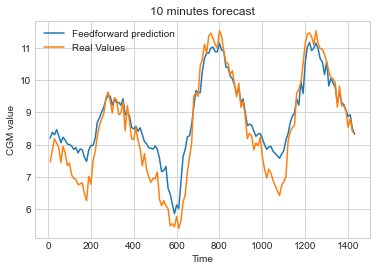

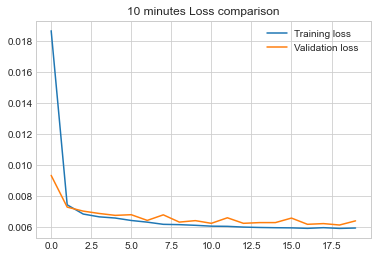

(756, 140, 3, 20)
here (756, 140, 3, 20) (324, 140, 3, 20)
shape (105840, 3, 20) (105840, 1)
Epoch 1/20
938/938 [==============================] - 6s 5ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 6/20
938/938 [===========================

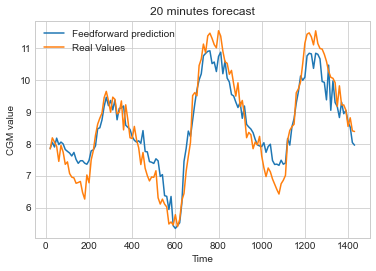

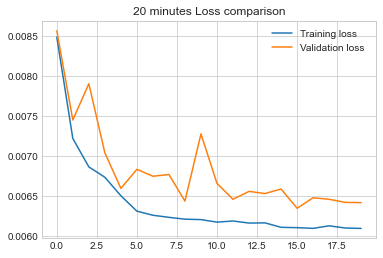

(756, 139, 3, 20)
here (756, 139, 3, 20) (324, 139, 3, 20)
shape (105084, 3, 20) (105084, 1)
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 6/20
938/938 [===========================

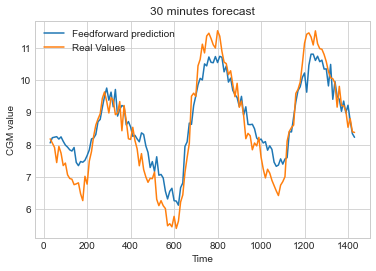

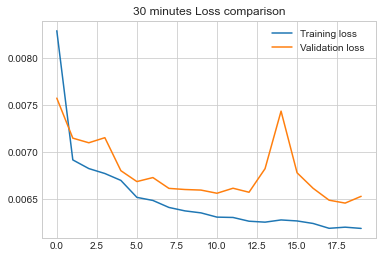

(756, 138, 3, 20)
here (756, 138, 3, 20) (324, 138, 3, 20)
shape (104328, 3, 20) (104328, 1)
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0880
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 6/20
938/938 [===========================

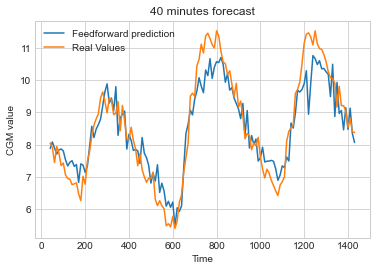

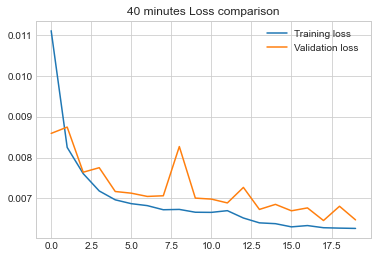

(756, 136, 3, 20)
here (756, 136, 3, 20) (324, 136, 3, 20)
shape (102816, 3, 20) (102816, 1)
Epoch 1/20
938/938 [==============================] - 4s 3ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 6/20
938/938 [===========================

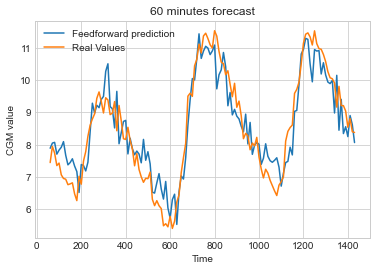

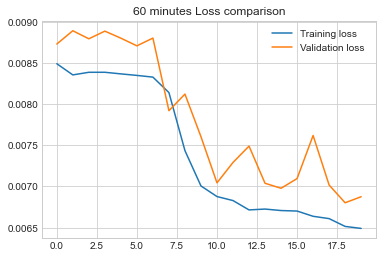

In [20]:
#### Running feedforward network for different time horizons ####
#start_time = time.time()
time_horizon=10
ff_min10=model1pred(time_horizon)
time_horizon=20
ff_min20=model1pred(time_horizon)
time_horizon=30
ff_min30=model1pred(time_horizon)
time_horizon=40
ff_min40=model1pred(time_horizon)
time_horizon=60
ff_min60=model1pred(time_horizon)

#print("--- %s running time ---" % (time.time() - start_time))

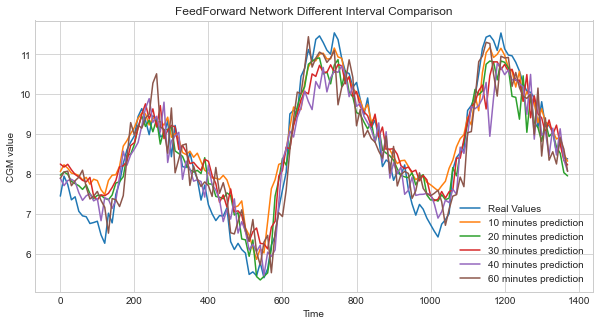

In [21]:
#### Feedforward network output for different time horizons ####

time3=np.arange(0,138)*10
plt.style.use('seaborn-whitegrid')
yplots=yplot(60)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(time3, yplots[0:138], label='Real Values')

plt.plot(time3, ff_min10[5:], label='10 minutes prediction')
plt.plot(time3, ff_min20[4:], label='20 minutes prediction')
plt.plot(time3, ff_min30[3:], label='30 minutes prediction')
plt.plot(time3, ff_min40[2:], label='40 minutes prediction')
plt.plot(time3, ff_min60, label='60 minutes prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title("FeedForward Network Different Interval Comparison")
plt.legend()
plt.show()

0.6031085125740012 0.5344846925193947 0.6131086653342661 0.6163088664787316 0.6183639853926729


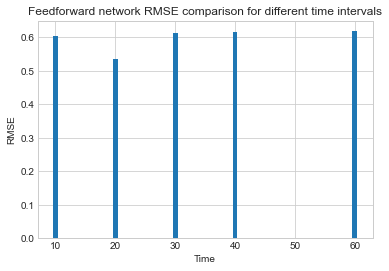

In [22]:
ff_rmse1=0
a=0
for i in range(5,len(ff_min10)):
    ff_rmse1+=(ff_min10[i]-yplots[a])**2
    a+=1
ff_rmse1=math.sqrt(ff_rmse1/len(ff_min10))


ff_rmse2=0
a=0
for i in range(4,len(ff_min20)):
    ff_rmse2+=(ff_min20[i]-yplots[a])**2
    a+=1
ff_rmse2=math.sqrt(ff_rmse2/len(ff_min20))

ff_rmse3=0
a=0
for i in range(3,len(ff_min30)):
    ff_rmse3+=(ff_min30[i]-yplots[a])**2
    a+=1
ff_rmse3=math.sqrt(ff_rmse3/len(ff_min30))

ff_rmse4=0
a=0
for i in range(2,len(ff_min40)):
    ff_rmse4+=(ff_min40[i]-yplots[a])**2
    a+=1
ff_rmse4=math.sqrt(ff_rmse4/len(ff_min40))

ff_rmse6=0
for i in range(len(ff_min60)):
    ff_rmse6+=(ff_min60[i]-yplots[i])**2
ff_rmse6=math.sqrt(ff_rmse6/len(ff_min60))


print(ff_rmse1,ff_rmse2,ff_rmse3,ff_rmse4,ff_rmse6)

hor=[10,20,30,40,60]
plt.bar(hor,[ff_rmse1,ff_rmse2,ff_rmse3,ff_rmse4,ff_rmse6])
plt.xlabel('Time')
plt.ylabel("RMSE")
plt.title('Feedforward network RMSE comparison for different time intervals')
plt.show()

In [23]:
#####LSTM model
def lstm_model(X,y):

    regressor2 = Sequential()
        
    regressor2.add(LSTM(units = 32, return_sequences = True, input_shape=(X.shape[1],X.shape[2])))
    regressor2.add(LSTM(units = 32,  return_sequences = True))
    #regressor2.add(Dropout(0.3))
    regressor2.add(LSTM(units = 32,  return_sequences = True))
    #regressor2.add(Dropout(0.3))
    regressor2.add(LSTM(units = 32,  return_sequences = True))
    regressor2.add(Dense(units = 8,activation='relu'))
    regressor2.add(Dense(units = 1,activation='linear'))
   
    #losses= tf.keras.losses.mean_squared_error(y,y_pred)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    regressor2.compile(optimizer = opt,  loss='mean_squared_error',metrics=["RootMeanSquaredError"])

    #regressor2.fit(np.array(X), np.array(y), epochs = 2, batch_size = 8)
    return regressor2

In [24]:
def model2_lstm(time_horizon):
    xtrain,y,test_data=dataproc(time_horizon)
    final_predictions_lstm=[]
    def lstm_modelNN(xtrain,y,test_data):
        #scaling()
        #print(xtrain,y,test_data)
        print(xtrain.shape,y.shape,test_data.shape)
        lstm_modelnn=lstm_model(xtrain, y)
        xval=xtrain[-15000:]
        yval=y[-15000:]
        xtrain=xtrain[:15000]
        y=y[:15000]
        #print(xval[0],"phoch",xtrain[0],"aage",y[0])
       
        #history=feedfwdm.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        history=lstm_modelnn.fit(xtrain, y,validation_data=(xval,yval), epochs = 50, batch_size = 128,verbose=1)
        #print(lstm_modelnn.summary())
        name='lstm'+str(time_horizon)
        pl=name+'.png'
        plot_model(lstm_modelnn,to_file=pl, show_shapes=True, show_layer_names=True)
        

        fin_lstm=lstm_modelnn.predict(test_data)
        print(np.array(fin_lstm).shape)
        for i in range(len(fin_lstm)):
            for j in range(len(fin_lstm[i])): 
                final_predictions_lstm.append(scg.inverse_transform(np.array(fin_lstm[i][j]).reshape(-1,1)))
        return history
    
    history=lstm_modelNN(xtrain,y,test_data) 
    return final_predictions_lstm,history
    

In [25]:
def model2pred(time_horizon):
    
    final_predictions_lstm,hist=model2_lstm(time_horizon)
    ff=[]
    #print(np.array(final_predictions_ff[0:138]))
    print("shape",np.array(final_predictions_lstm).shape)
    for j in range(144-int(time_horizon/10)):
        ff.append((final_predictions_lstm[j][0]))   
    yplots=yplot(time_horizon)
    time3=np.arange(time_horizon,1440,10)
    plt.style.use('seaborn-whitegrid')
    plt.plot(time3, ff, label='LSTM prediction')
    plt.plot(time3, yplots[0:144-int(time_horizon/10)], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    t=str(time_horizon)+' minutes forecast'
    plt.title(t)
    plt.legend()
    plt.show()
    val=hist.history['val_loss']
    loss=hist.history['loss']
    x=np.arange(0,50,1)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val, label='Validation loss ')
    t=str(time_horizon)+' minutes Loss comparison'
    plt.title(t)
    plt.legend()
    plt.show()
    return ff

(756, 143, 3) (756, 143) (324, 143, 3)
Epoch 1/50
6/6 [==============================] - 9s 612ms/step - loss: 0.0682 - root_mean_squared_error: 0.2612 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 2/50
6/6 [==============================] - 2s 319ms/step - loss: 0.0107 - root_mean_squared_error: 0.1037 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 3/50
6/6 [==============================] - 2s 421ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 4/50
6/6 [==============================] - 2s 361ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 5/50
6/6 [==============================] - 2s 353ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 6/50
6/6 [==============================] - 2s 315ms/step - loss: 0.0064 - root_mean_squared_error: 0.079

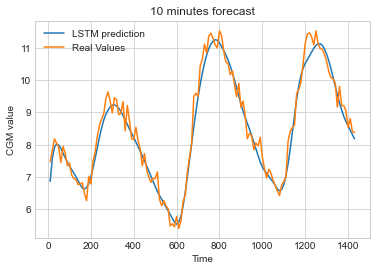

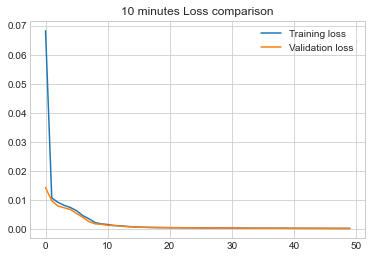

(756, 142, 3) (756, 142) (324, 142, 3)
Epoch 1/50
6/6 [==============================] - 8s 609ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 2/50
6/6 [==============================] - 2s 310ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 3/50
6/6 [==============================] - 2s 331ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 4/50
6/6 [==============================] - 2s 323ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 5/50
6/6 [==============================] - 2s 306ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 6/50
6/6 [==============================] - 2s 328ms/step - loss: 0.0035 - root_mean_squared_error: 0.058

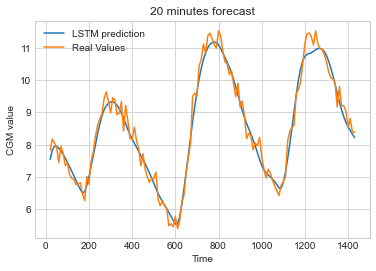

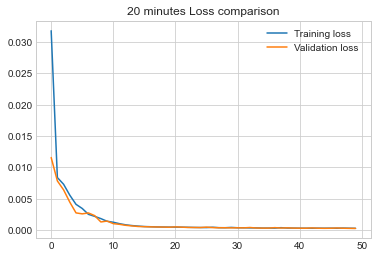

(756, 141, 3) (756, 141) (324, 141, 3)
Epoch 1/50
6/6 [==============================] - 8s 564ms/step - loss: 0.0505 - root_mean_squared_error: 0.2247 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 2/50
6/6 [==============================] - 2s 408ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 3/50
6/6 [==============================] - 2s 355ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 4/50
6/6 [==============================] - 2s 419ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 5/50
6/6 [==============================] - 2s 398ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 6/50
6/6 [==============================] - 3s 531ms/step - loss: 0.0069 - root_mean_squared_error: 0.082

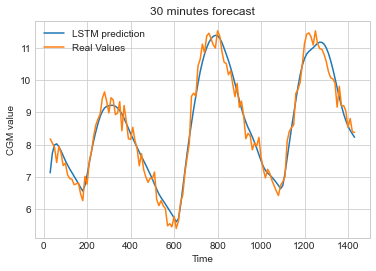

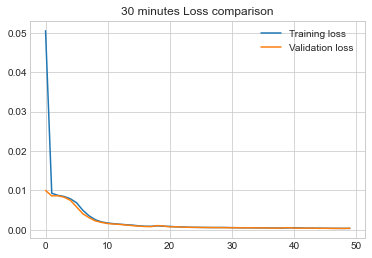

(756, 140, 3) (756, 140) (324, 140, 3)
Epoch 1/50
6/6 [==============================] - 9s 635ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630
Epoch 2/50
6/6 [==============================] - 2s 339ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 3/50
6/6 [==============================] - 2s 329ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 4/50
6/6 [==============================] - 2s 362ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 5/50
6/6 [==============================] - 2s 323ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 6/50
6/6 [==============================] - 2s 322ms/step - loss: 0.0083 - root_mean_squared_error: 0.090

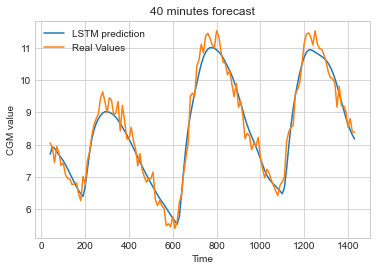

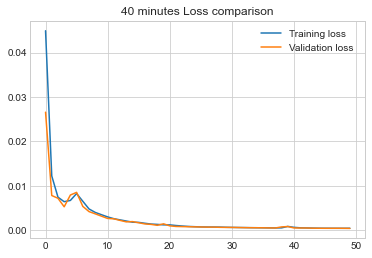

(756, 138, 3) (756, 138) (324, 138, 3)
Epoch 1/50
6/6 [==============================] - 9s 633ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 2/50
6/6 [==============================] - 2s 348ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 3/50
6/6 [==============================] - 2s 321ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 4/50
6/6 [==============================] - 2s 341ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 5/50
6/6 [==============================] - 2s 356ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 6/50
6/6 [==============================] - 2s 314ms/step - loss: 0.0052 - root_mean_squared_error: 0.072

Epoch 48/50
6/6 [==============================] - 2s 368ms/step - loss: 5.8495e-04 - root_mean_squared_error: 0.0242 - val_loss: 5.7822e-04 - val_root_mean_squared_error: 0.0240
Epoch 49/50
6/6 [==============================] - 2s 402ms/step - loss: 5.7450e-04 - root_mean_squared_error: 0.0240 - val_loss: 5.7047e-04 - val_root_mean_squared_error: 0.0239
Epoch 50/50
6/6 [==============================] - 2s 446ms/step - loss: 5.7608e-04 - root_mean_squared_error: 0.0240 - val_loss: 5.9509e-04 - val_root_mean_squared_error: 0.0244
(324, 138, 1)
shape (44712, 1, 1)


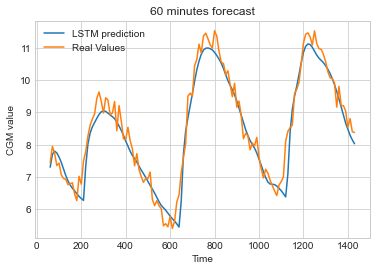

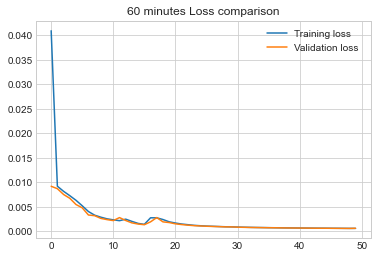

In [26]:
#### LSTM network run for different time horizons ####
#start_time=time.time()
time_horizon=10
lstm_min10=model2pred(time_horizon)
time_horizon=20
lstm_min20=model2pred(time_horizon)
time_horizon=30
lstm_min30=model2pred(time_horizon)
time_horizon=40
lstm_min40=model2pred(time_horizon)
time_horizon=60
lstm_min60=model2pred(time_horizon)
#print("--- %s Running time ---" % (time.time() - start_time))



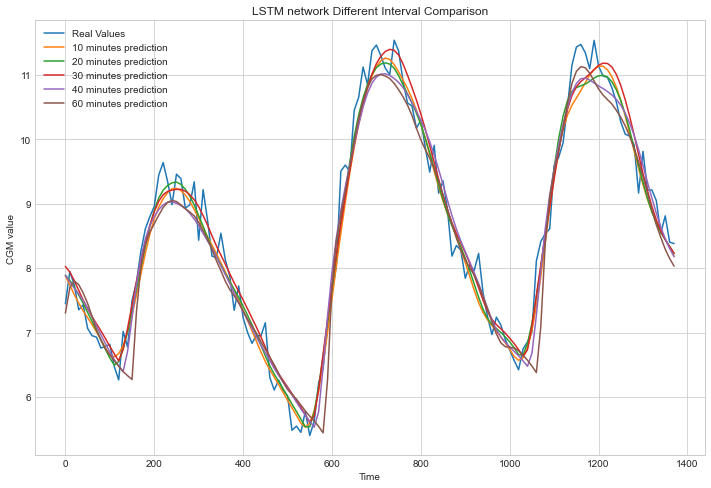

In [27]:
#### LSTM network output for different time horizons ####

time3=np.arange(0,138)*10
plt.style.use('seaborn-whitegrid')
yplots=yplot(60)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time3, yplots[0:144-int(60/10)], label='Real Values')

plt.plot(time3, lstm_min10[5:], label='10 minutes prediction')
plt.plot(time3, lstm_min20[4:], label='20 minutes prediction')
plt.plot(time3, lstm_min30[3:], label='30 minutes prediction')
plt.plot(time3, lstm_min40[2:], label='40 minutes prediction')
plt.plot(time3, lstm_min60, label='60 minutes prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title("LSTM network Different Interval Comparison")
plt.legend()
plt.show()

0.2967373629291973 0.27338663718053535 0.2961125370396469 0.31461865351038587 0.3936366523600057


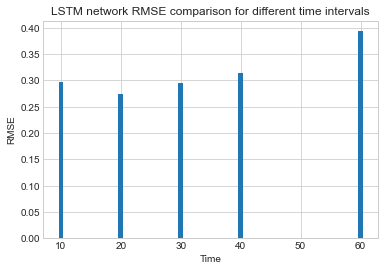

In [28]:
lstm_rmse1=0
a=0
for i in range(5,len(lstm_min10)):
    lstm_rmse1+=(lstm_min10[i]-yplots[a])**2
    a+=1
lstm_rmse1=math.sqrt(lstm_rmse1/len(lstm_min10))


lstm_rmse2=0
a=0
for i in range(4,len(lstm_min20)):
    lstm_rmse2+=(lstm_min20[i]-yplots[a])**2
    a+=1
lstm_rmse2=math.sqrt(lstm_rmse2/len(lstm_min20))

lstm_rmse3=0
a=0
for i in range(3,len(lstm_min30)):
    lstm_rmse3+=(lstm_min30[i]-yplots[a])**2
    a+=1
lstm_rmse3=math.sqrt(lstm_rmse3/len(lstm_min30))

lstm_rmse4=0
a=0
for i in range(2,len(lstm_min40)):
    lstm_rmse4+=(lstm_min40[i]-yplots[a])**2
    a+=1
lstm_rmse4=math.sqrt(lstm_rmse4/len(lstm_min40))

lstm_rmse6=0
for i in range(len(lstm_min60)):
    lstm_rmse6+=(lstm_min60[i]-yplots[i])**2
lstm_rmse6=math.sqrt(lstm_rmse6/len(lstm_min60))


print(lstm_rmse1,lstm_rmse2,lstm_rmse3,lstm_rmse4,lstm_rmse6)

hor=[10,20,30,40,60]
plt.bar(hor,[lstm_rmse1,lstm_rmse2,lstm_rmse3,lstm_rmse4,lstm_rmse6])
plt.xlabel('Time')
plt.ylabel("RMSE")
plt.title('LSTM network RMSE comparison for different time intervals')
plt.show()

In [29]:
'''final_predictions_lstm=model2_lstm(True)
lst=[]
for i in range(len(final_predictions_lstm[0])):
    lst.append(final_predictions_lstm[0][i])
yplot=yplot30min()
time3=np.arange(30,1440,10)
plt.plot(time3, lst, label='LSTM prediction')
plt.plot(time3, yplot[0:141], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()



final_predictions_lstm=model2_lstm(False)
lst3=[]
for i in range(len(final_predictions_lstm[0])):
    lst3.append(final_predictions_lstm[0][i])
yplot=yplot60min()
time=np.arange(60,1440,10)
plt.plot(time, lst3, label='LSTM prediction')
plt.plot(time, yplot[0:138], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('60 minute forecast')
plt.legend()
plt.show()

'''

"final_predictions_lstm=model2_lstm(True)\nlst=[]\nfor i in range(len(final_predictions_lstm[0])):\n    lst.append(final_predictions_lstm[0][i])\nyplot=yplot30min()\ntime3=np.arange(30,1440,10)\nplt.plot(time3, lst, label='LSTM prediction')\nplt.plot(time3, yplot[0:141], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('30 minute forecast')\nplt.legend()\nplt.show()\n\n\n\nfinal_predictions_lstm=model2_lstm(False)\nlst3=[]\nfor i in range(len(final_predictions_lstm[0])):\n    lst3.append(final_predictions_lstm[0][i])\nyplot=yplot60min()\ntime=np.arange(60,1440,10)\nplt.plot(time, lst3, label='LSTM prediction')\nplt.plot(time, yplot[0:138], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('60 minute forecast')\nplt.legend()\nplt.show()\n\n"

In [30]:
'''cc=0
rr=0
yplot=yplot30min()

for i in range(len(final_predictions_lstm[0])):
    cc=cc+abs(final_predictions_lstm[0][i]-yplot[i])
    rr=rr+(final_predictions_lstm[0][i]-yplot[i])**2
    print(final_predictions_lstm[0][i],yplot[i])
print(cc,math.sqrt(rr/len(final_predictions_lstm[0])))'''

'cc=0\nrr=0\nyplot=yplot30min()\n\nfor i in range(len(final_predictions_lstm[0])):\n    cc=cc+abs(final_predictions_lstm[0][i]-yplot[i])\n    rr=rr+(final_predictions_lstm[0][i]-yplot[i])**2\n    print(final_predictions_lstm[0][i],yplot[i])\nprint(cc,math.sqrt(rr/len(final_predictions_lstm[0])))'

In [31]:
#####CNN model#####
def CNNModel(X,y):

    regressor2 = Sequential()
        
    regressor2.add(Conv1D(16,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='valid'))

    regressor2.add(Conv1D(32,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))
    regressor2.add(Conv1D(64,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))
    regressor2.add(Conv1D(128,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))
    
   
    regressor2.add(Flatten())
    regressor2.add(Dense(units = 8,activation='relu'))
    regressor2.add(Dense(units = 1,activation='linear'))
   
    #losses= tf.keras.losses.mean_squared_error(y,y_pred)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    regressor2.compile(optimizer = opt,  loss='mean_squared_error',metrics=["RootMeanSquaredError"])

    #regressor2.fit(np.array(X), np.array(y), epochs = 2, batch_size = 8)
    return regressor2

In [32]:
def model3_cnn(time_horizon):
    xtrain,y,test_data=mansplit(time_horizon)
    final_predictions_CNN=[]
    xtrain=np.reshape(xtrain, (xtrain.shape[0]* xtrain.shape[1], xtrain.shape[2],xtrain.shape[3] ))
    y=np.reshape(y, (y.shape[0]* y.shape[1], y.shape[2] ))
    test_data=np.reshape(test_data, (test_data.shape[0]* test_data.shape[1], test_data.shape[2],test_data.shape[3] ))
    print("shape",xtrain.shape,y.shape)
    def CNN_modelNN(xtrain,y,test_data):
        #scaling()
        #print(xtrain,y,test_data)
        Cnn_model=CNNModel(xtrain, y)
        xval=xtrain[-30000:]
        yval=y[-30000:]
        xtrain=xtrain[:30000]
        y=y[:30000]
        #print(xval[0],"phoch",xtrain[0],"aage",y[0])
       
        #history=feedfwdm.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        #print(Cnn_model.summary())
        history=Cnn_model.fit(xtrain, y,validation_data=(xval,yval), epochs = 40,verbose=1)
        name='cnn'+str(time_horizon)
        pl=name+'.png'
        plot_model(Cnn_model,to_file=pl, show_shapes=True, show_layer_names=True)
        

        fin_cnn=Cnn_model.predict(test_data)
        print(np.array(fin_cnn).shape)
        print(fin_cnn[0])
        for i in range(len(fin_cnn)):
            #for j in range(len(fin_cnn[i])):
                final_predictions_CNN.append(scg.inverse_transform(np.array(fin_cnn[i]).reshape(-1,1)))
        return history
    
    history=CNN_modelNN(xtrain,y,test_data)
    return final_predictions_CNN,history



In [33]:
def model3pred(time_horizon):
    
    final_predictions_CNN,hist=model3_cnn(time_horizon)
    ff=[]
    #print(np.array(final_predictions_ff[0:138]))
    print("shape",np.array(final_predictions_CNN).shape)
    for j in range(144-int(time_horizon/10)):
        ff.append((final_predictions_CNN[j][0]))   
    yplots=yplot(time_horizon)
    time3=np.arange(time_horizon,1440,10)
    plt.style.use('seaborn-whitegrid')
    plt.plot(time3, ff, label='CNN prediction')
    plt.plot(time3, yplots[0:144-int(time_horizon/10)], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    t=str(time_horizon)+' minutes forecast'
    plt.title(t)
    plt.legend()
    plt.show()
    val=hist.history['val_loss']
    loss=hist.history['loss']
    x=np.arange(0,40,1)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val, label='Validation loss ')
    t=str(time_horizon)+' minutes Loss comparison'
    plt.title(t)
    plt.legend()
    plt.show()
    return ff

(142, 10)
(756, 142, 3, 10) (324, 142, 3, 10)
shape (107352, 3, 10) (107352, 1)
Epoch 1/40
938/938 [==============================] - 4s 3ms/step - loss: 7.3763e-04 - root_mean_squared_error: 0.0272 - val_loss: 3.0263e-04 - val_root_mean_squared_error: 0.0174
Epoch 2/40
938/938 [==============================] - 3s 4ms/step - loss: 2.4062e-04 - root_mean_squared_error: 0.0155 - val_loss: 2.4087e-04 - val_root_mean_squared_error: 0.0155
Epoch 3/40
938/938 [==============================] - 3s 3ms/step - loss: 2.4724e-04 - root_mean_squared_error: 0.0157 - val_loss: 2.3029e-04 - val_root_mean_squared_error: 0.0152
Epoch 4/40
938/938 [==============================] - 4s 4ms/step - loss: 2.3139e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.8863e-04 - val_root_mean_squared_error: 0.0170
Epoch 5/40
938/938 [==============================] - 5s 5ms/step - loss: 2.3029e-04 - root_mean_squared_error: 0.0152 - val_loss: 1.9677e-04 - val_root_mean_squared_error: 0.0140
Epoch 6/40
938/938 [

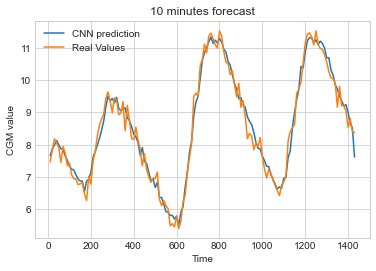

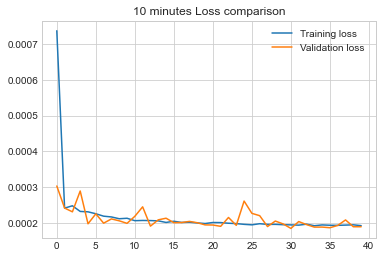

(141, 10)
(756, 141, 3, 10) (324, 141, 3, 10)
shape (106596, 3, 10) (106596, 1)
Epoch 1/40
938/938 [==============================] - 4s 4ms/step - loss: 6.8344e-04 - root_mean_squared_error: 0.0261 - val_loss: 4.5169e-04 - val_root_mean_squared_error: 0.0213
Epoch 2/40
938/938 [==============================] - 3s 3ms/step - loss: 3.7468e-04 - root_mean_squared_error: 0.0194 - val_loss: 3.1910e-04 - val_root_mean_squared_error: 0.0179
Epoch 3/40
938/938 [==============================] - 3s 3ms/step - loss: 3.5907e-04 - root_mean_squared_error: 0.0189 - val_loss: 3.7898e-04 - val_root_mean_squared_error: 0.0195
Epoch 4/40
938/938 [==============================] - 5s 5ms/step - loss: 3.5722e-04 - root_mean_squared_error: 0.0189 - val_loss: 5.0934e-04 - val_root_mean_squared_error: 0.0226
Epoch 5/40
938/938 [==============================] - 3s 4ms/step - loss: 3.4479e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.2396e-04 - val_root_mean_squared_error: 0.0180
Epoch 6/40
938/938 [

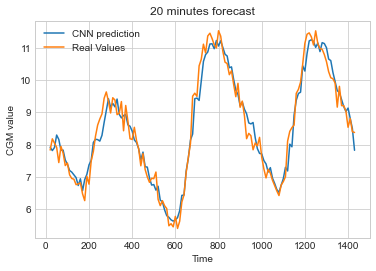

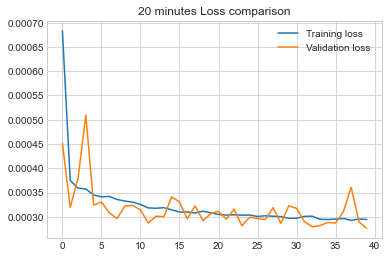

(140, 10)
(756, 140, 3, 10) (324, 140, 3, 10)
shape (105840, 3, 10) (105840, 1)
Epoch 1/40
938/938 [==============================] - 5s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 5.2745e-04 - val_root_mean_squared_error: 0.0230
Epoch 2/40
938/938 [==============================] - 4s 4ms/step - loss: 6.2279e-04 - root_mean_squared_error: 0.0250 - val_loss: 5.5728e-04 - val_root_mean_squared_error: 0.0236
Epoch 3/40
938/938 [==============================] - 4s 4ms/step - loss: 6.0377e-04 - root_mean_squared_error: 0.0246 - val_loss: 4.9919e-04 - val_root_mean_squared_error: 0.0223
Epoch 4/40
938/938 [==============================] - 4s 4ms/step - loss: 5.6554e-04 - root_mean_squared_error: 0.0238 - val_loss: 5.2369e-04 - val_root_mean_squared_error: 0.0229
Epoch 5/40
938/938 [==============================] - 4s 4ms/step - loss: 5.5535e-04 - root_mean_squared_error: 0.0236 - val_loss: 5.5505e-04 - val_root_mean_squared_error: 0.0236
Epoch 6/40
938/938 [====

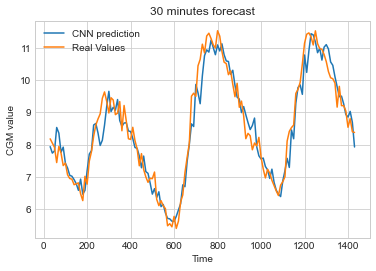

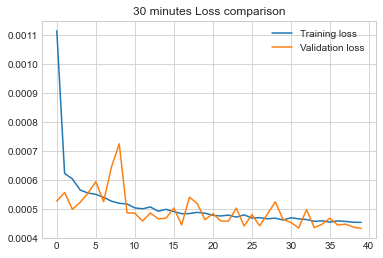

(139, 10)
(756, 139, 3, 10) (324, 139, 3, 10)
shape (105084, 3, 10) (105084, 1)
Epoch 1/40
938/938 [==============================] - 4s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 9.8708e-04 - val_root_mean_squared_error: 0.0314
Epoch 2/40
938/938 [==============================] - 3s 4ms/step - loss: 9.6448e-04 - root_mean_squared_error: 0.0311 - val_loss: 8.9905e-04 - val_root_mean_squared_error: 0.0300
Epoch 3/40
938/938 [==============================] - 3s 4ms/step - loss: 8.9866e-04 - root_mean_squared_error: 0.0300 - val_loss: 8.9075e-04 - val_root_mean_squared_error: 0.0298
Epoch 4/40
938/938 [==============================] - 3s 3ms/step - loss: 8.5254e-04 - root_mean_squared_error: 0.0292 - val_loss: 8.1864e-04 - val_root_mean_squared_error: 0.0286
Epoch 5/40
938/938 [==============================] - 3s 3ms/step - loss: 8.4748e-04 - root_mean_squared_error: 0.0291 - val_loss: 8.2831e-04 - val_root_mean_squared_error: 0.0288
Epoch 6/40
938/938 [====

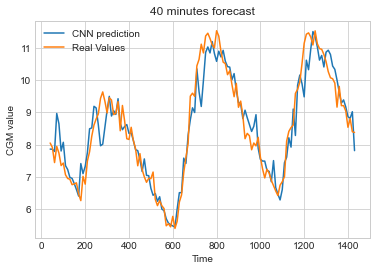

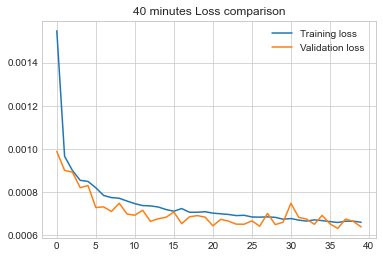

(137, 10)
(756, 137, 3, 10) (324, 137, 3, 10)
shape (103572, 3, 10) (103572, 1)
Epoch 1/40
938/938 [==============================] - 4s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 2/40
938/938 [==============================] - 4s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 3/40
938/938 [==============================] - 3s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 4/40
938/938 [==============================] - 4s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 5/40
938/938 [==============================] - 3s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/40
938/938 [==============================] - 3s 3ms

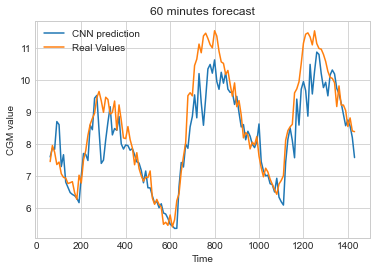

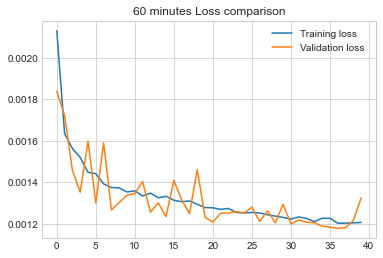

In [34]:
#start_time=time.time()
time_horizon=10
cnn_min10=model3pred(time_horizon)
time_horizon=20
cnn_min20=model3pred(time_horizon)
time_horizon=30
cnn_min30=model3pred(time_horizon)
time_horizon=40
cnn_min40=model3pred(time_horizon)
time_horizon=60
cnn_min60=model3pred(time_horizon)
#print("--- %s Running time ---" % (time.time() - start_time))



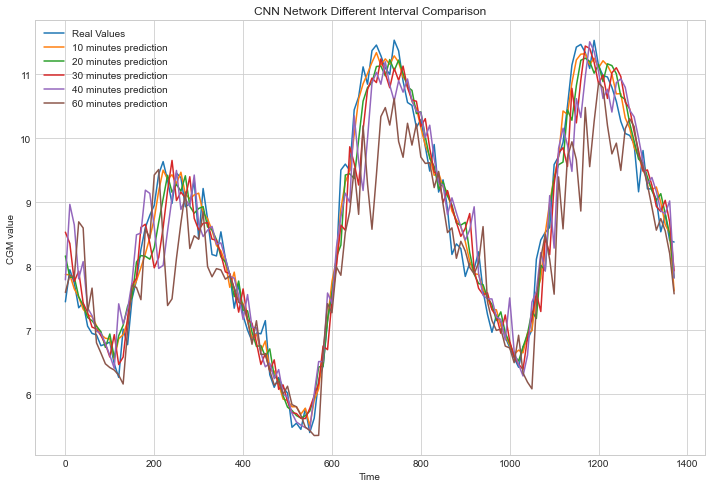

In [35]:
time3=np.arange(0,138)*10
plt.style.use('seaborn-whitegrid')
yplots=yplot(60)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time3, yplots[0:144-int(60/10)], label='Real Values')

plt.plot(time3, cnn_min10[5:], label='10 minutes prediction')
plt.plot(time3, cnn_min20[4:], label='20 minutes prediction')
plt.plot(time3, cnn_min30[3:], label='30 minutes prediction')
plt.plot(time3, cnn_min40[2:], label='40 minutes prediction')
plt.plot(time3, cnn_min60, label='60 minutes prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title("CNN Network Different Interval Comparison")
plt.legend()
plt.show()

0.26322499305235253 0.352965627844766 0.4457975389544437 0.5281639502343024 0.7764876746005761


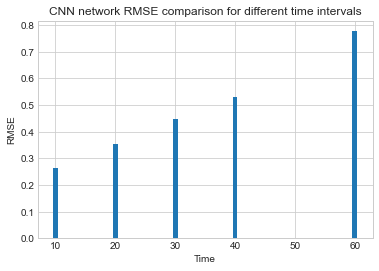

In [36]:
cnn_rmse1=0
a=0
for i in range(5,len(cnn_min10)):
    cnn_rmse1+=(cnn_min10[i]-yplots[a])**2
    a+=1
cnn_rmse1=math.sqrt(cnn_rmse1/len(cnn_min10))


cnn_rmse2=0
a=0
for i in range(4,len(cnn_min20)):
    cnn_rmse2+=(cnn_min20[i]-yplots[a])**2
    a+=1
cnn_rmse2=math.sqrt(cnn_rmse2/len(cnn_min20))

cnn_rmse3=0
a=0
for i in range(3,len(cnn_min30)):
    cnn_rmse3+=(cnn_min30[i]-yplots[a])**2
    a+=1
cnn_rmse3=math.sqrt(cnn_rmse3/len(cnn_min30))

cnn_rmse4=0
a=0
for i in range(2,len(cnn_min40)):
    cnn_rmse4+=(cnn_min40[i]-yplots[a])**2
    a+=1
cnn_rmse4=math.sqrt(cnn_rmse4/len(cnn_min40))

cnn_rmse6=0
for i in range(len(cnn_min60)):
    cnn_rmse6+=(cnn_min60[i]-yplots[i])**2
cnn_rmse6=math.sqrt(cnn_rmse6/len(cnn_min60))


print(cnn_rmse1,cnn_rmse2,cnn_rmse3,cnn_rmse4,cnn_rmse6)

hor=[10,20,30,40,60]
plt.bar(hor,[cnn_rmse1,cnn_rmse2,cnn_rmse3,cnn_rmse4,cnn_rmse6])
plt.xlabel('Time')
plt.ylabel("RMSE")
plt.title('CNN network RMSE comparison for different time intervals')
plt.show()

In [37]:
'''final_predictions_CNN=model3_cnn(True)
cnn=[]

yplot=yplot30min()
print("final_predictions_CNN",np.array(final_predictions_CNN).shape)
for i in range(141):
    cnn.append(final_predictions_CNN[i][0])
time3=np.arange(30,1440,10)

plt.plot(time3, cnn, label='CNN prediction')

plt.plot(time3, yplot[0:141], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()



final_predictions_CNN=model3_cnn(False)
cnn3=[]

yplot=yplot60min()
for i in range(len(final_predictions_CNN[0])):
    cnn3.append(final_predictions_CNN[0][i])
plt.plot(time, cnn3, label='CNN prediction')

plt.plot(time, yplot[0:138], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('60 minute forecast')
plt.legend()
plt.show()
'''


'final_predictions_CNN=model3_cnn(True)\ncnn=[]\n\nyplot=yplot30min()\nprint("final_predictions_CNN",np.array(final_predictions_CNN).shape)\nfor i in range(141):\n    cnn.append(final_predictions_CNN[i][0])\ntime3=np.arange(30,1440,10)\n\nplt.plot(time3, cnn, label=\'CNN prediction\')\n\nplt.plot(time3, yplot[0:141], label=\'Real Values\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'CGM value\')\nplt.title(\'30 minute forecast\')\nplt.legend()\nplt.show()\n\n\n\nfinal_predictions_CNN=model3_cnn(False)\ncnn3=[]\n\nyplot=yplot60min()\nfor i in range(len(final_predictions_CNN[0])):\n    cnn3.append(final_predictions_CNN[0][i])\nplt.plot(time, cnn3, label=\'CNN prediction\')\n\nplt.plot(time, yplot[0:138], label=\'Real Values\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'CGM value\')\nplt.title(\'60 minute forecast\')\nplt.legend()\nplt.show()\n'

In [38]:
#####CNN+LSTM model
def CNNLSTM(X,y):

    regressor2 = Sequential()
        
    regressor2.add(Conv1D(16,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='valid'))
    regressor2.add(Conv1D(32,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))
    regressor2.add(Conv1D(64,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))
    '''regressor2.add(Conv1D(128,3,padding='same'))
    regressor2.add(MaxPool1D(pool_size=2,strides=1,padding='same'))'''
    regressor2.add(TimeDistributed(Flatten()))
    regressor2.add(LSTM(units = 32, return_sequences = True))
    regressor2.add(LSTM(units = 32,  return_sequences = True))
    
    regressor2.add(Dense(units = 8,activation='relu'))
    regressor2.add(Dense(units = 1,activation='linear'))
   
    #losses= tf.keras.losses.mean_squared_error(y,y_pred)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    regressor2.compile(optimizer = opt,  loss='mean_squared_error',metrics=["RootMeanSquaredError"])

    #regressor2.fit(np.array(X), np.array(y), epochs = 2, batch_size = 8)
    return regressor2

In [39]:
def model4_cnnlstm(time_horizon):
    xtrain,y,test_data=mansplit(time_horizon)
    final_predictions_CNNlstm=[]
    xtrain=np.reshape(xtrain, (xtrain.shape[0]* xtrain.shape[1], xtrain.shape[2],xtrain.shape[3] ))
    y=np.reshape(y, (y.shape[0]* y.shape[1], y.shape[2] ))
    test_data=np.reshape(test_data, (test_data.shape[0]* test_data.shape[1], test_data.shape[2],test_data.shape[3] ))
    print("shape",xtrain.shape,y.shape)
    def CNNlstm_modelNN(xtrain,y,test_data):
        #scaling()
        #print(xtrain,y,test_data)
        Cnn_model=CNNLSTM(xtrain, y)
        xval=xtrain[-15000:]
        yval=y[-15000:]
        xtrain=xtrain[:15000]
        y=y[:15000]
        #print(xval[0],"phoch",xtrain[0],"aage",y[0])
       
        #history=feedfwdm.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        history=Cnn_model.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        name='cnnlstm'+str(time_horizon)
        pl=name+'.png'
        plot_model(Cnn_model,to_file=pl, show_shapes=True, show_layer_names=True)

        fin_cnn=Cnn_model.predict(test_data)
        print(np.array(fin_cnn).shape)
        print(fin_cnn[0],fin_cnn[1])
        for i in range(len(fin_cnn)):
            final_predictions_CNNlstm.append(scg.inverse_transform(fin_cnn[i]))
        print(scg.inverse_transform(fin_cnn[0]),scg.inverse_transform(fin_cnn[1]))
        return history
        
    history=CNNlstm_modelNN(xtrain,y,test_data)
    return final_predictions_CNNlstm,history




    




In [40]:
def model4pred(time_horizon):
    
    final_predictions_CNNlstm,hist=model4_cnnlstm(time_horizon)
    ff=[]
    #print(np.array(final_predictions_ff[0:138]))
    print("shape",np.array(final_predictions_CNNlstm).shape)
    for j in range(144-int(time_horizon/10)):
        ff.append((final_predictions_CNNlstm[j][0]))   
    yplots=yplot(time_horizon)
    time3=np.arange(time_horizon,1440,10)
    plt.style.use('seaborn-whitegrid')
    plt.plot(time3, ff, label='CNN+LSTM prediction')
    plt.plot(time3, yplots[0:144-int(time_horizon/10)], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    t=str(time_horizon)+' minutes forecast'
    plt.title(t)
    plt.legend()
    plt.show()
    val=hist.history['val_loss']
    loss=hist.history['loss']
    x=np.arange(0,20,1)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val, label='Validation loss ')
    t=str(time_horizon)+' minutes Loss comparison'
    plt.title(t)
    plt.legend()
    plt.show()
    return ff

(142, 10)
(756, 142, 3, 10) (324, 142, 3, 10)
shape (107352, 3, 10) (107352, 1)
Epoch 1/20
469/469 [==============================] - 8s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 2.8892e-04 - val_root_mean_squared_error: 0.0170
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 2.4399e-04 - root_mean_squared_error: 0.0156 - val_loss: 2.1544e-04 - val_root_mean_squared_error: 0.0147
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 2.1857e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.4137e-04 - val_root_mean_squared_error: 0.0155
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 2.2355e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.7791e-04 - val_root_mean_squared_error: 0.0167
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 2.1830e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.2916e-04 - val_root_mean_squared_error: 0.0151
Epoch 6/20
469/469 [====

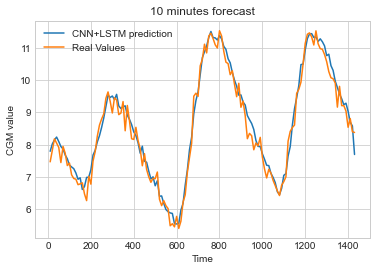

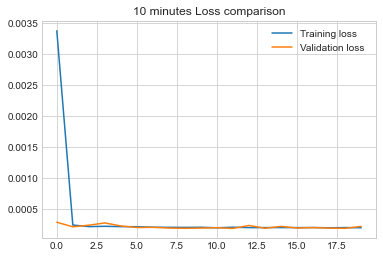

(141, 10)
(756, 141, 3, 10) (324, 141, 3, 10)
shape (106596, 3, 10) (106596, 1)
Epoch 1/20
469/469 [==============================] - 9s 12ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 4.5285e-04 - val_root_mean_squared_error: 0.0213
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 4.1579e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.6379e-04 - val_root_mean_squared_error: 0.0191
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 3.8159e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.2887e-04 - val_root_mean_squared_error: 0.0181
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 3.6404e-04 - root_mean_squared_error: 0.0191 - val_loss: 3.8580e-04 - val_root_mean_squared_error: 0.0196
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 3.5351e-04 - root_mean_squared_error: 0.0188 - val_loss: 3.1464e-04 - val_root_mean_squared_error: 0.0177
Epoch 6/20
469/469 [==

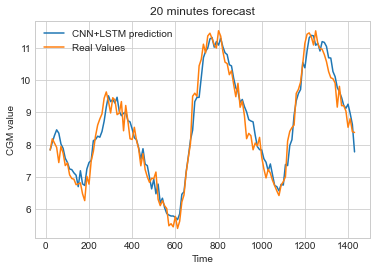

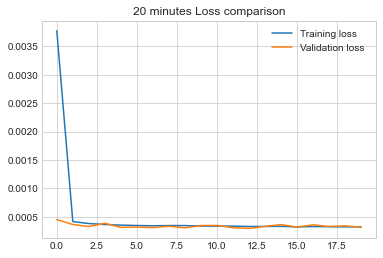

(140, 10)
(756, 140, 3, 10) (324, 140, 3, 10)
shape (105840, 3, 10) (105840, 1)
Epoch 1/20
469/469 [==============================] - 8s 9ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 7.1910e-04 - val_root_mean_squared_error: 0.0268
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 7.1327e-04 - root_mean_squared_error: 0.0267 - val_loss: 5.9711e-04 - val_root_mean_squared_error: 0.0244
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 6.5646e-04 - root_mean_squared_error: 0.0256 - val_loss: 6.5398e-04 - val_root_mean_squared_error: 0.0256
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 6.4586e-04 - root_mean_squared_error: 0.0254 - val_loss: 5.6345e-04 - val_root_mean_squared_error: 0.0237
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 6.2613e-04 - root_mean_squared_error: 0.0250 - val_loss: 5.8664e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/20
469/469 [====

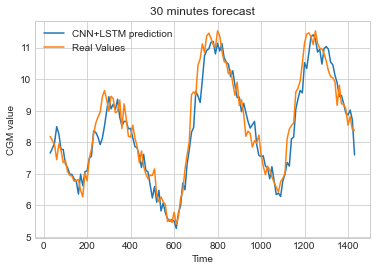

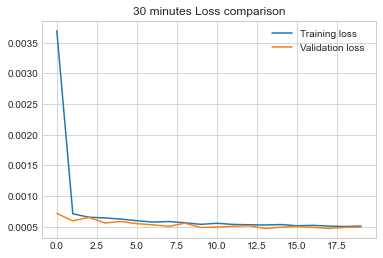

(139, 10)
(756, 139, 3, 10) (324, 139, 3, 10)
shape (105084, 3, 10) (105084, 1)
Epoch 1/20
469/469 [==============================] - 8s 10ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 9.8168e-04 - val_root_mean_squared_error: 0.0313
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 9.7835e-04 - root_mean_squared_error: 0.0313 - val_loss: 8.4963e-04 - val_root_mean_squared_error: 0.0291
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 9.6227e-04 - root_mean_squared_error: 0.0310 - val_loss: 8.9528e-04 - val_root_mean_squared_error: 0.0299
Epoch 6/20
469/469 [==================

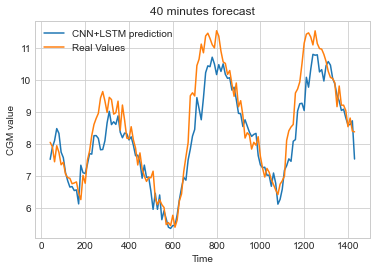

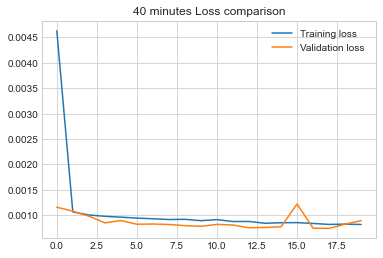

(137, 10)
(756, 137, 3, 10) (324, 137, 3, 10)
shape (103572, 3, 10) (103572, 1)
Epoch 1/20
469/469 [==============================] - 8s 10ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 6/20
469/469 [==============================] - 4s 8m

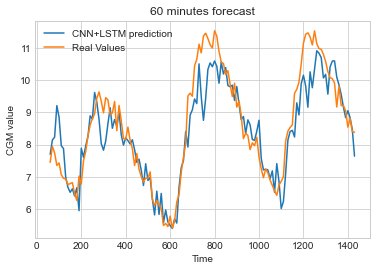

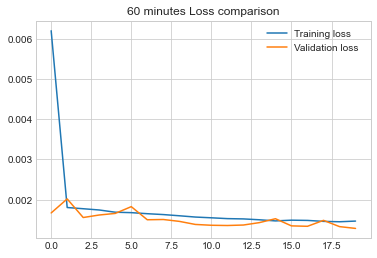

In [41]:
#tart_time=time.time()
time_horizon=10
cnnlstm_min10=model4pred(time_horizon)
time_horizon=20
cnnlstm_min20=model4pred(time_horizon)
time_horizon=30
cnnlstm_min30=model4pred(time_horizon)
time_horizon=40
cnnlstm_min40=model4pred(time_horizon)
time_horizon=60
cnnlstm_min60=model4pred(time_horizon)

#print("--- %s Running time ---" % (time.time() - start_time))


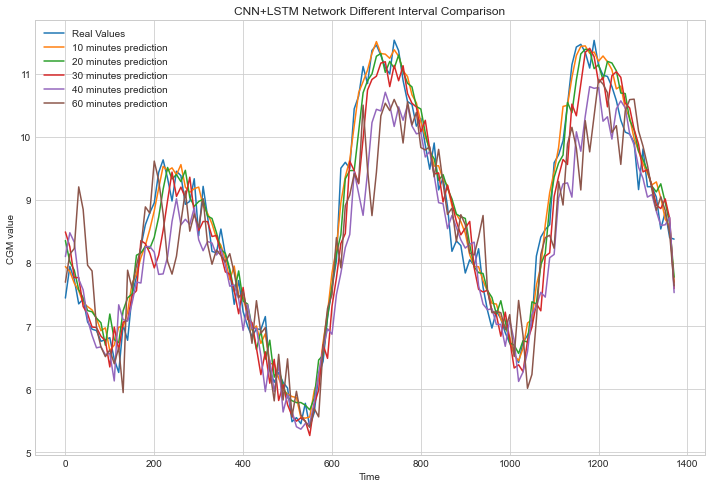

In [42]:
time3=np.arange(0,138)*10
plt.style.use('seaborn-whitegrid')
yplots=yplot(60)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time3, yplots[0:144-int(60/10)], label='Real Values')

plt.plot(time3, cnnlstm_min10[5:], label='10 minutes prediction')
plt.plot(time3, cnnlstm_min20[4:], label='20 minutes prediction')
plt.plot(time3, cnnlstm_min30[3:], label='30 minutes prediction')
plt.plot(time3, cnnlstm_min40[2:], label='40 minutes prediction')
plt.plot(time3, cnnlstm_min60, label='60 minutes prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title("CNN+LSTM Network Different Interval Comparison")
plt.legend()
plt.show()

0.27821346708301814 0.35461119028363436 0.47277806816616375 0.6828476458131065 0.7230632975901418


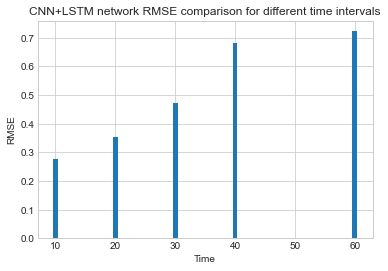

In [43]:
cnnlstm_rmse1=0
a=0
for i in range(5,len(cnnlstm_min10)):
    cnnlstm_rmse1+=(cnnlstm_min10[i]-yplots[a])**2
    a+=1
cnnlstm_rmse1=math.sqrt(cnnlstm_rmse1/len(cnnlstm_min10))


cnnlstm_rmse2=0
a=0
for i in range(4,len(cnnlstm_min20)):
    cnnlstm_rmse2+=(cnnlstm_min20[i]-yplots[a])**2
    a+=1
cnnlstm_rmse2=math.sqrt(cnnlstm_rmse2/len(cnnlstm_min20))

cnnlstm_rmse3=0
a=0
for i in range(3,len(cnnlstm_min30)):
    cnnlstm_rmse3+=(cnnlstm_min30[i]-yplots[a])**2
    a+=1
cnnlstm_rmse3=math.sqrt(cnnlstm_rmse3/len(cnnlstm_min30))

cnnlstm_rmse4=0
a=0
for i in range(2,len(cnnlstm_min40)):
    cnnlstm_rmse4+=(cnnlstm_min40[i]-yplots[a])**2
    a+=1
cnnlstm_rmse4=math.sqrt(cnnlstm_rmse4/len(cnnlstm_min40))

cnnlstm_rmse6=0
for i in range(len(cnnlstm_min60)):
    cnnlstm_rmse6+=(cnnlstm_min60[i]-yplots[i])**2
cnnlstm_rmse6=math.sqrt(cnnlstm_rmse6/len(cnnlstm_min60))


print(cnnlstm_rmse1,cnnlstm_rmse2,cnnlstm_rmse3,cnnlstm_rmse4,cnnlstm_rmse6)

hor=[10,20,30,40,60]
plt.bar(hor,[cnnlstm_rmse1,cnnlstm_rmse2,cnnlstm_rmse3,cnnlstm_rmse4,cnnlstm_rmse6])
plt.xlabel('Time')
plt.ylabel("RMSE")
plt.title('CNN+LSTM network RMSE comparison for different time intervals')
plt.show()

In [44]:
'''final_predictions_CNNlstm=model4_cnnlstm(True)
cnnlst=[]

yplot=yplot30min()
for i in range(len(final_predictions_CNNlstm[0])):
    cnnlst.append(final_predictions_CNNlstm[0][i])


plt.style.use('seaborn-whitegrid')
    
plt.plot(time3, cnnlst, label='CNN+LSTM prediction')
plt.plot(time3, yplot[0:141], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()



final_predictions_CNNlstm=model4_cnnlstm(False)
cnnlst3=[]
time=np.arange(60,1440,10)

yplot=yplot60min()
for i in range(len(final_predictions_CNNlstm[0])):
    cnnlst3.append(final_predictions_CNNlstm[0][i])
    
plt.plot(time, cnnlst3, label='CNN+LSTM prediction')
plt.plot(time, yplot[0:138], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('60 minute forecast')
plt.legend()
plt.show()

'''

"final_predictions_CNNlstm=model4_cnnlstm(True)\ncnnlst=[]\n\nyplot=yplot30min()\nfor i in range(len(final_predictions_CNNlstm[0])):\n    cnnlst.append(final_predictions_CNNlstm[0][i])\n\n\nplt.style.use('seaborn-whitegrid')\n    \nplt.plot(time3, cnnlst, label='CNN+LSTM prediction')\nplt.plot(time3, yplot[0:141], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('30 minute forecast')\nplt.legend()\nplt.show()\n\n\n\nfinal_predictions_CNNlstm=model4_cnnlstm(False)\ncnnlst3=[]\ntime=np.arange(60,1440,10)\n\nyplot=yplot60min()\nfor i in range(len(final_predictions_CNNlstm[0])):\n    cnnlst3.append(final_predictions_CNNlstm[0][i])\n    \nplt.plot(time, cnnlst3, label='CNN+LSTM prediction')\nplt.plot(time, yplot[0:138], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('60 minute forecast')\nplt.legend()\nplt.show()\n\n"

In [45]:
def BiDirLstm():
    regressor2 = Sequential()
    regressor2.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
    regressor2.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
    #regressor2.add(Dropout(0.3))
    regressor2.add(Bidirectional(LSTM(units = 32, return_sequences = True)))

    regressor2.add(Dense(units = 8,activation='relu'))
    regressor2.add(Dense(units = 1,activation='linear'))
   
    #losses= tf.keras.losses.mean_squared_error(y,y_pred)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    regressor2.compile(optimizer = opt,  loss='mean_squared_error',metrics=["RootMeanSquaredError"])

    #regressor2.fit(np.array(X), np.array(y), epochs = 2, batch_size = 8)
    return regressor2


In [46]:
def model5_bilstm(time_horizon):
    xtrain,y,test_data=dataproc(time_horizon)

    final_predictions_bi=[]
    def bi_modelNN(xtrain,y,test_data):
        #scaling()
        #print(xtrain,y,test_data)
        
        Bi_model=BiDirLstm()
        xval=xtrain[-15000:]
        yval=y[-15000:]
        xtrain=xtrain[:15000]
        y=y[:15000]
        #print(xval[0],"phoch",xtrain[0],"aage",y[0])
       
        #history=feedfwdm.fit(xtrain, y,validation_data=(xval,yval), epochs = 20,verbose=1)
        history=Bi_model.fit(xtrain, y,validation_data=(xval,yval), epochs = 40, batch_size = 128,verbose=1)
        name='bi'+str(time_horizon)
        pl=name+'.png'
        plot_model(Bi_model,to_file=pl, show_shapes=True, show_layer_names=True)
        


        #visualizer(Bi_model, filename=name, format='png', view=True)

        fin_bi=Bi_model.predict(test_data)
        print(np.array(fin_bi).shape)
        for i in range(len(fin_bi)):
            for j in range(len(fin_bi[i])):
                final_predictions_bi.append(scg.inverse_transform(np.array(fin_bi[i][j]).reshape(-1,1)))
        return history
    
    history=bi_modelNN(xtrain,y,test_data)   
    return final_predictions_bi,history



In [47]:
def model5pred(time_horizon):
    
    final_predictions_bi,hist=model5_bilstm(time_horizon)
    ff=[]
    #print(np.array(final_predictions_ff[0:138]))
    print("shape",np.array(final_predictions_bi).shape)
    for j in range(144-int(time_horizon/10)):
        ff.append((final_predictions_bi[j][0]))   
    yplots=yplot(time_horizon)
    time3=np.arange(time_horizon,1440,10)
    plt.style.use('seaborn-whitegrid')
    plt.plot(time3, ff, label='BiDirectional LSTM prediction')
    plt.plot(time3, yplots[0:144-int(time_horizon/10)], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    t=str(time_horizon)+' minutes forecast'
    plt.title(t)
    plt.legend()
    plt.show()
    val=hist.history['val_loss']
    loss=hist.history['loss']
    x=np.arange(0,40,1)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val, label='Validation loss ')
    t=str(time_horizon)+' minutes Loss comparison'
    plt.title(t)
    plt.legend()
    plt.show()
    return ff

Epoch 1/40
6/6 [==============================] - 13s 916ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 2/40
6/6 [==============================] - 2s 425ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 3/40
6/6 [==============================] - 3s 448ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 4/40
6/6 [==============================] - 3s 466ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 5/40
6/6 [==============================] - 3s 452ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 6/40
6/6 [==============================] - 3s 488ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0015 - val_root_mean_s

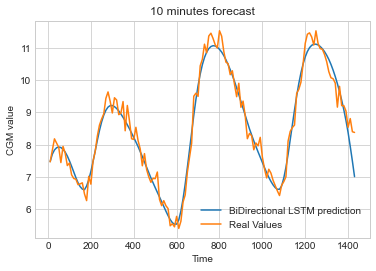

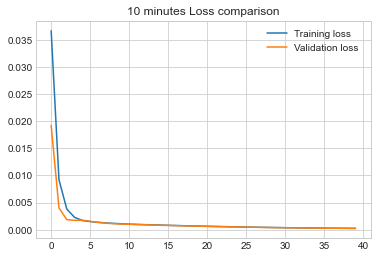

Epoch 1/40
6/6 [==============================] - 14s 994ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 2/40
6/6 [==============================] - 3s 547ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 3/40
6/6 [==============================] - 3s 466ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 4/40
6/6 [==============================] - 3s 530ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 5/40
6/6 [==============================] - 3s 492ms/step - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 6/40
6/6 [==============================] - 3s 548ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0017 - val_root_mean_s

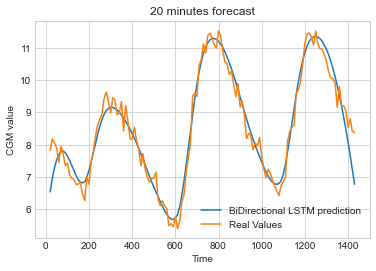

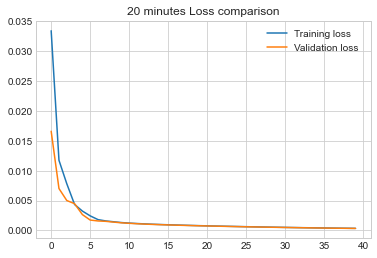

Epoch 1/40
6/6 [==============================] - 13s 836ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 2/40
6/6 [==============================] - 4s 748ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 3/40
6/6 [==============================] - 3s 619ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 4/40
6/6 [==============================] - 4s 639ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 5/40
6/6 [==============================] - 4s 709ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 6/40
6/6 [==============================] - 5s 806ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0013 - val_root_mean_s

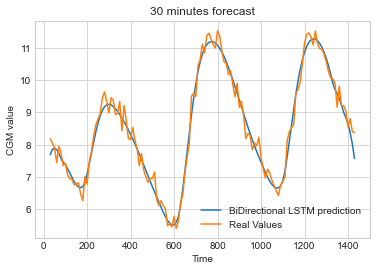

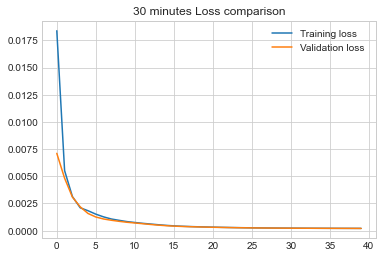

Epoch 1/40
6/6 [==============================] - 13s 856ms/step - loss: 0.0350 - root_mean_squared_error: 0.1872 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 2/40
6/6 [==============================] - 3s 614ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 3/40
6/6 [==============================] - 4s 756ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 4/40
6/6 [==============================] - 3s 557ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 5/40
6/6 [==============================] - 3s 595ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 6/40
6/6 [==============================] - 3s 548ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0018 - val_root_mean_s

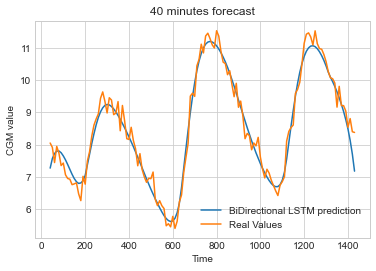

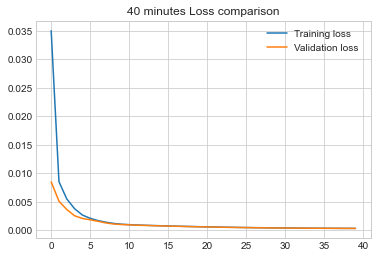

Epoch 1/40
6/6 [==============================] - 13s 884ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 2/40
6/6 [==============================] - 3s 595ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 3/40
6/6 [==============================] - 3s 600ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 4/40
6/6 [==============================] - 3s 546ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 5/40
6/6 [==============================] - 3s 571ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 6/40
6/6 [==============================] - 3s 547ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0027 - val_root_mean_s

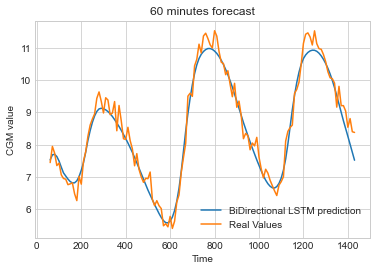

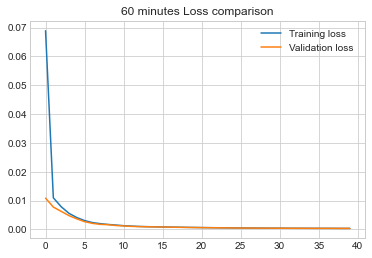

--- 803.1431803703308 Running time ---


In [48]:
start_time=time.time()
time_horizon=10
bilstm_min10=model5pred(time_horizon)
time_horizon=20
bilstm_min20=model5pred(time_horizon)
time_horizon=30
bilstm_min30=model5pred(time_horizon)
time_horizon=40
bilstm_min40=model5pred(time_horizon)
time_horizon=60
bilstm_min60=model5pred(time_horizon)
print("--- %s Running time ---" % (time.time() - start_time))



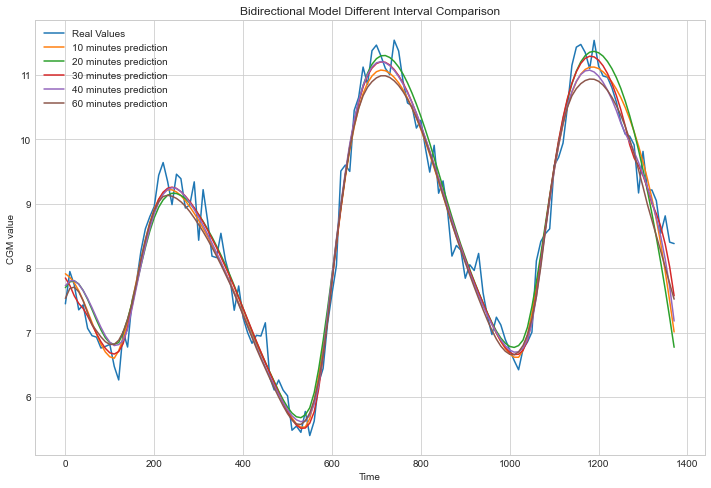

In [49]:
time3=np.arange(0,138)*10
plt.style.use('seaborn-whitegrid')
yplots=yplot(60)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time3, yplots[0:144-int(60/10)], label='Real Values')

plt.plot(time3, bilstm_min10[5:], label='10 minutes prediction')
plt.plot(time3, bilstm_min20[4:], label='20 minutes prediction')
plt.plot(time3, bilstm_min30[3:], label='30 minutes prediction')
plt.plot(time3, bilstm_min40[2:], label='40 minutes prediction')
plt.plot(time3, bilstm_min60, label='60 minutes prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title("Bidirectional Model Different Interval Comparison")
plt.legend()
plt.show()

0.30502499937178335 0.3464745357797955 0.25290953802613114 0.29495402028305157 0.3166295899887907


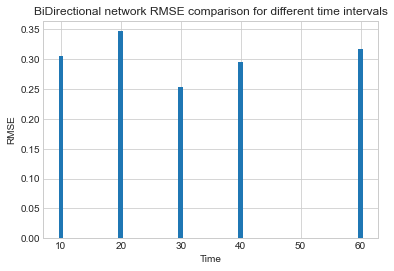

In [50]:
bilstm_rmse1=0
a=0
for i in range(5,len(bilstm_min10)):
    bilstm_rmse1+=(bilstm_min10[i]-yplots[a])**2
    a+=1
bilstm_rmse1=math.sqrt(bilstm_rmse1/len(bilstm_min10))


bilstm_rmse2=0
a=0
for i in range(4,len(bilstm_min20)):
    bilstm_rmse2+=(bilstm_min20[i]-yplots[a])**2
    a+=1
bilstm_rmse2=math.sqrt(bilstm_rmse2/len(bilstm_min20))

bilstm_rmse3=0
a=0
for i in range(3,len(bilstm_min30)):
    bilstm_rmse3+=(bilstm_min30[i]-yplots[a])**2
    a+=1
bilstm_rmse3=math.sqrt(bilstm_rmse3/len(bilstm_min30))

bilstm_rmse4=0
a=0
for i in range(2,len(bilstm_min40)):
    bilstm_rmse4+=(bilstm_min40[i]-yplots[a])**2
    a+=1
bilstm_rmse4=math.sqrt(bilstm_rmse4/len(bilstm_min40))

bilstm_rmse6=0
for i in range(len(bilstm_min60)):
    bilstm_rmse6+=(bilstm_min60[i]-yplots[i])**2
bilstm_rmse6=math.sqrt(bilstm_rmse6/len(bilstm_min60))


print(bilstm_rmse1,bilstm_rmse2,bilstm_rmse3,bilstm_rmse4,bilstm_rmse6)

hor=[10,20,30,40,60]
plt.bar(hor,[bilstm_rmse1,bilstm_rmse2,bilstm_rmse3,bilstm_rmse4,bilstm_rmse6])
plt.xlabel('Time')
plt.ylabel("RMSE")
plt.title('BiDirectional network RMSE comparison for different time intervals')
plt.show()

In [51]:
'''final_predictions_bi=model5_bilstm(True)
bi=[]

yplot=yplot30min()
for i in range(len(final_predictions_bi[0])):
    bi.append(final_predictions_bi[0][i])


plt.plot(time3, bi, label='BiDirectional LSTM prediction')
plt.plot(time3, yplot[0:141], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()   



final_predictions_bi=model5_bilstm(False)
bi3=[]

yplot=yplot60min()
for i in range(len(final_predictions_bi[0])):
    bi3.append(final_predictions_bi[0][i])


plt.plot(time, bi3, label='BiDirectional LSTM prediction')
plt.plot(time, yplot[0:138], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('60 minute forecast')
plt.legend()
plt.show()   


'''

"final_predictions_bi=model5_bilstm(True)\nbi=[]\n\nyplot=yplot30min()\nfor i in range(len(final_predictions_bi[0])):\n    bi.append(final_predictions_bi[0][i])\n\n\nplt.plot(time3, bi, label='BiDirectional LSTM prediction')\nplt.plot(time3, yplot[0:141], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('30 minute forecast')\nplt.legend()\nplt.show()   \n\n\n\nfinal_predictions_bi=model5_bilstm(False)\nbi3=[]\n\nyplot=yplot60min()\nfor i in range(len(final_predictions_bi[0])):\n    bi3.append(final_predictions_bi[0][i])\n\n\nplt.plot(time, bi3, label='BiDirectional LSTM prediction')\nplt.plot(time, yplot[0:138], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('60 minute forecast')\nplt.legend()\nplt.show()   \n\n\n"

In [52]:
##########Different models plot for 10 minutes interval##########

def modplot10():
    time=np.arange(0,143)
    yplots=yplot(10)
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    plt.plot(time, ff_min10, label='Feedforward prediction')
    plt.plot(time, cnn_min10, label='CNN prediction')
    plt.plot(time, lstm_min10, label='LSTM prediction')
    plt.plot(time, cnnlstm_min10, label='CNN+LSTM prediction')
    plt.plot(time, bilstm_min10, label='BiDirectional LSTM prediction')
    plt.plot(time, yplots[0:143], label='Real Values')
    plt.xlabel('Models')
    plt.ylabel('CGM value')
    plt.title('10 minute model comparison')
    plt.legend()
    plt.show()
    f = plt.figure(figsize = (8,4))

    hor=['Feedforward','CNN','LSTM','CNN+LSTM','BiDirectional LSTM']
    plt.bar(hor,[ff_rmse1,cnn_rmse1,lstm_rmse1,cnnlstm_rmse1,bilstm_rmse1])
    plt.xlabel('Time')
    plt.ylabel("RMSE")
    plt.title('10 minutes RMSE comparison for different models')
    plt.show()

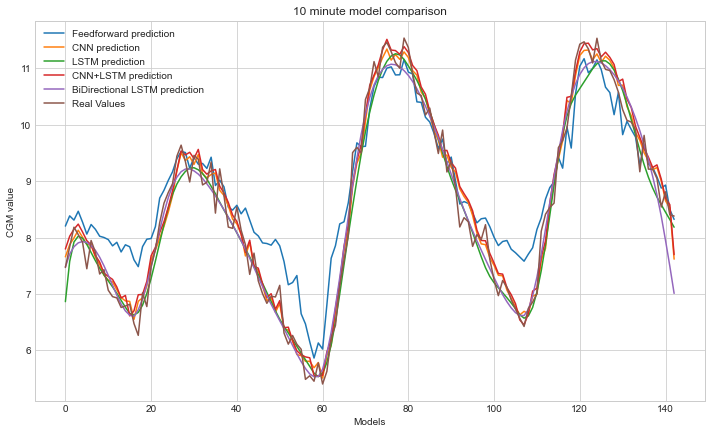

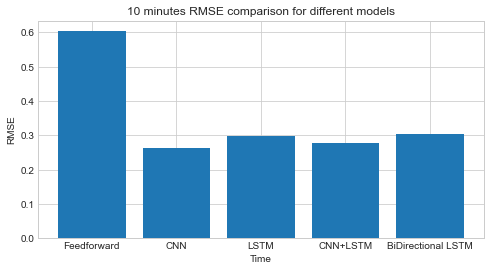

In [53]:
modplot10()


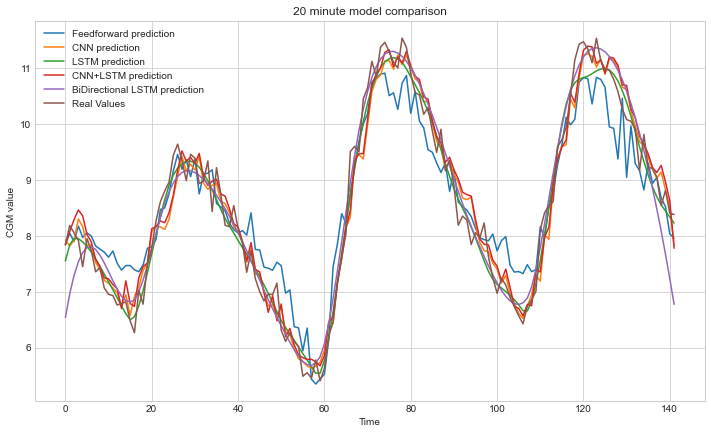

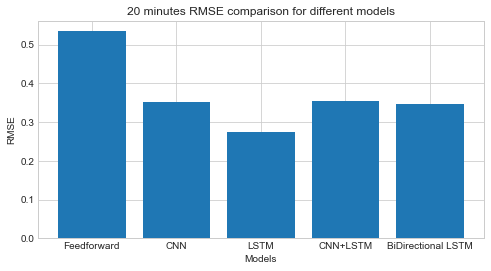

In [54]:
def modplot20():
    time=np.arange(0,142)
    yplots=yplot(20)
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    plt.plot(time, ff_min20, label='Feedforward prediction')
    plt.plot(time, cnn_min20, label='CNN prediction')
    plt.plot(time, lstm_min20, label='LSTM prediction')
    plt.plot(time, cnnlstm_min20, label='CNN+LSTM prediction')
    plt.plot(time, bilstm_min20, label='BiDirectional LSTM prediction')
    plt.plot(time, yplots[0:142], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    plt.title('20 minute model comparison')
    plt.legend()
    plt.show()
    f = plt.figure(figsize = (8,4))

    hor=['Feedforward','CNN','LSTM','CNN+LSTM','BiDirectional LSTM']
    plt.bar(hor,[ff_rmse2,cnn_rmse2,lstm_rmse2,cnnlstm_rmse2,bilstm_rmse2])
    plt.xlabel('Models')
    plt.ylabel("RMSE")
    plt.title('20 minutes RMSE comparison for different models')
    plt.show()
    
modplot20()


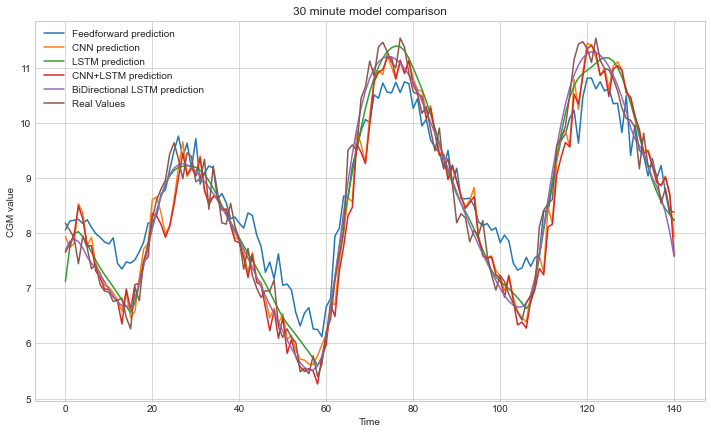

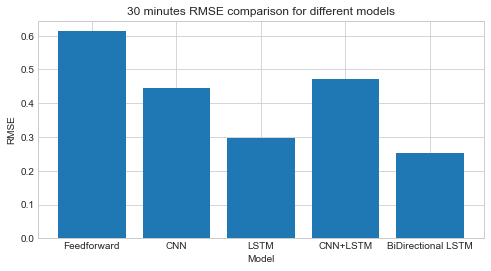

In [55]:
def modplot30():
    time=np.arange(0,141)
    yplots=yplot(30)
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    plt.plot(time, ff_min30, label='Feedforward prediction')
    plt.plot(time, cnn_min30, label='CNN prediction')
    plt.plot(time, lstm_min30, label='LSTM prediction')
    plt.plot(time, cnnlstm_min30, label='CNN+LSTM prediction')
    plt.plot(time, bilstm_min30, label='BiDirectional LSTM prediction')
    plt.plot(time, yplots[0:141], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    plt.title('30 minute model comparison')
    plt.legend()
    plt.show()
    f = plt.figure(figsize = (8,4))
    hor=['Feedforward','CNN','LSTM','CNN+LSTM','BiDirectional LSTM']
    plt.bar(hor,[ff_rmse3,cnn_rmse3,lstm_rmse3,cnnlstm_rmse3,bilstm_rmse3])
    plt.xlabel('Model')
    plt.ylabel("RMSE")
    plt.title('30 minutes RMSE comparison for different models')
    plt.show()
    
modplot30()


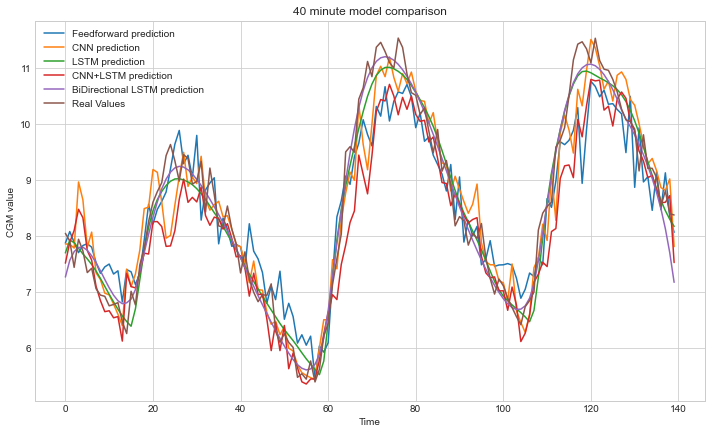

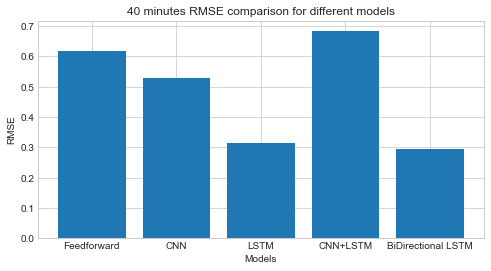

In [56]:
def modplot40():
    time=np.arange(0,140)
    yplots=yplot(40)
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    plt.plot(time, ff_min40, label='Feedforward prediction')
    plt.plot(time, cnn_min40, label='CNN prediction')
    plt.plot(time, lstm_min40, label='LSTM prediction')
    plt.plot(time, cnnlstm_min40, label='CNN+LSTM prediction')
    plt.plot(time, bilstm_min40, label='BiDirectional LSTM prediction')
    plt.plot(time, yplots[0:140], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    plt.title('40 minute model comparison')
    plt.legend()
    plt.show()
    f = plt.figure(figsize = (8,4))

    hor=['Feedforward','CNN','LSTM','CNN+LSTM','BiDirectional LSTM']
    plt.bar(hor,[ff_rmse4,cnn_rmse4,lstm_rmse4,cnnlstm_rmse4,bilstm_rmse4])
    plt.xlabel('Models')
    plt.ylabel("RMSE")
    plt.title('40 minutes RMSE comparison for different models')
    plt.show()
    
modplot40()


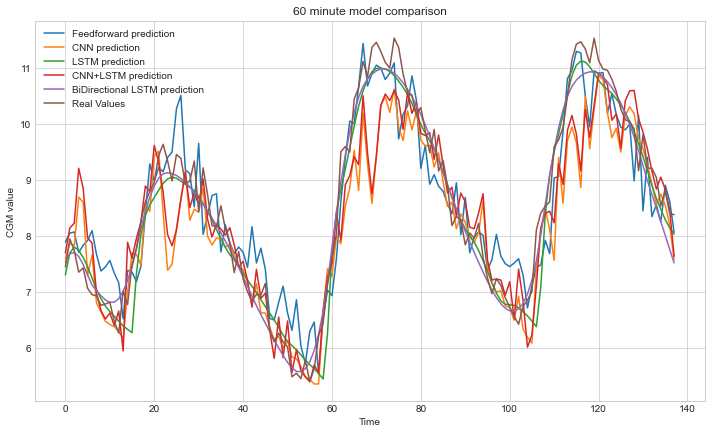

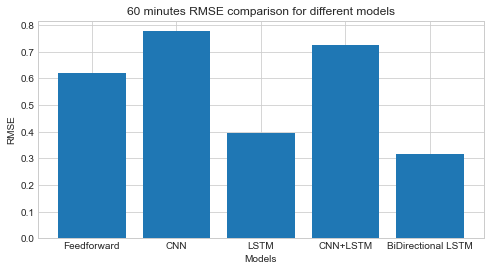

In [57]:
def modplot60():
    time=np.arange(0,138)
    yplots=yplot(60)
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    plt.plot(time, ff_min60, label='Feedforward prediction')
    plt.plot(time, cnn_min60, label='CNN prediction')
    plt.plot(time, lstm_min60, label='LSTM prediction')
    plt.plot(time, cnnlstm_min60, label='CNN+LSTM prediction')
    plt.plot(time, bilstm_min60, label='BiDirectional LSTM prediction')
    plt.plot(time, yplots[0:138], label='Real Values')
    plt.xlabel('Time')
    plt.ylabel('CGM value')
    plt.title('60 minute model comparison')
    plt.legend()
    plt.show()
    f = plt.figure(figsize = (8,4))

    hor=['Feedforward','CNN','LSTM','CNN+LSTM','BiDirectional LSTM']
    plt.bar(hor,[ff_rmse6,cnn_rmse6,lstm_rmse6,cnnlstm_rmse6,bilstm_rmse6])
    plt.xlabel('Models')
    plt.ylabel("RMSE")
    plt.title('60 minutes RMSE comparison for different models')
    plt.show()
    
modplot60()


In [58]:
'''time=np.arange(30,1440,10)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time, ff, label='Feedforward prediction')
plt.plot(time, cnn, label='CNN prediction')
plt.plot(time, lst, label='LSTM prediction')
plt.plot(time, cnnlst, label='CNN+LSTM prediction')
plt.plot(time, bi, label='BiDirectional LSTM prediction')
plt.plot(time, yplot[0:141], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()
'''

"time=np.arange(30,1440,10)\n\nf = plt.figure()\nf.set_figwidth(12)\nf.set_figheight(8)\nplt.plot(time, ff, label='Feedforward prediction')\nplt.plot(time, cnn, label='CNN prediction')\nplt.plot(time, lst, label='LSTM prediction')\nplt.plot(time, cnnlst, label='CNN+LSTM prediction')\nplt.plot(time, bi, label='BiDirectional LSTM prediction')\nplt.plot(time, yplot[0:141], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('30 minute forecast')\nplt.legend()\nplt.show()\n"

In [59]:
'''time=np.arange(60,1440,10)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(time, ff3, label='Feedforward prediction')
plt.plot(time, cnn3, label='CNN prediction')
plt.plot(time, lst3, label='LSTM prediction')
plt.plot(time, cnnlst3, label='CNN+LSTM prediction')
plt.plot(time, bi3, label='BiDirectional LSTM prediction')
plt.plot(time, yplot[0:138], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('60 minute forecast')
plt.legend()
plt.show()
'''

"time=np.arange(60,1440,10)\n\nf = plt.figure()\nf.set_figwidth(12)\nf.set_figheight(8)\nplt.plot(time, ff3, label='Feedforward prediction')\nplt.plot(time, cnn3, label='CNN prediction')\nplt.plot(time, lst3, label='LSTM prediction')\nplt.plot(time, cnnlst3, label='CNN+LSTM prediction')\nplt.plot(time, bi3, label='BiDirectional LSTM prediction')\nplt.plot(time, yplot[0:138], label='Real Values')\nplt.xlabel('Time')\nplt.ylabel('CGM value')\nplt.title('60 minute forecast')\nplt.legend()\nplt.show()\n"

In [60]:

#feedfwd.fit(newd, y, epochs = 40, batch_size = 128,verbose=1)

In [61]:
#lstm_model.fit(newd, y, epochs = 40, batch_size = 128,verbose=1)

In [62]:
#CNNModel.fit(newd, y, epochs = 40, batch_size = 128,verbose=1)

In [63]:
#CNNLSTM.fit(newd, y, epochs = 50, batch_size = 128,verbose=1)

In [64]:
'''fin_feedfwd=feedfwd.predict(test_data)
fin_lstm=lstm_model.predict(test_data)
fin_CNNModel=CNNModel.predict(test_data)
fin_CNNLSTM=CNNLSTM.predict(test_data)
'''

'fin_feedfwd=feedfwd.predict(test_data)\nfin_lstm=lstm_model.predict(test_data)\nfin_CNNModel=CNNModel.predict(test_data)\nfin_CNNLSTM=CNNLSTM.predict(test_data)\n'

In [65]:
'''from statsmodels.tsa.ar_model import AutoReg
#####Getting the real Glucose values#####
test_values = yplot(10)


def yploty(time_horizon):
    yplot=np.zeros((len(tr_glucoseo)*(144-int(time_horizon/10))))
    x=0
    for i in range(len(tr_glucoseo)):
        
        av=0
        for j in range(time_horizon,len(tr_glucoseo[i]),10):
            
            yplot[x]=tr_glucoseo[i][j]
            #print("ih",i,j,te_glucoseo[i][j],yplot[x],x)
            x+=1
    return yplot

train=yploty(10)
model = AutoReg(train, 1,old_names=False).fit()


forecasts = model.predict().tolist()
time=np.arange(0,143)
plt.plot(time, forecasts[0:143], label='Autoregressive prediction')
plt.plot(time, yplots[0:143], label='Real Values')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('10 minute model comparison')
plt.legend()
plt.show()
#for index in range(len(forecasts)):
      #print(forecasts[index], test_values[index])
#predict  vs forecast?'''

'from statsmodels.tsa.ar_model import AutoReg\n#####Getting the real Glucose values#####\ntest_values = yplot(10)\n\n\ndef yploty(time_horizon):\n    yplot=np.zeros((len(tr_glucoseo)*(144-int(time_horizon/10))))\n    x=0\n    for i in range(len(tr_glucoseo)):\n        \n        av=0\n        for j in range(time_horizon,len(tr_glucoseo[i]),10):\n            \n            yplot[x]=tr_glucoseo[i][j]\n            #print("ih",i,j,te_glucoseo[i][j],yplot[x],x)\n            x+=1\n    return yplot\n\ntrain=yploty(10)\nmodel = AutoReg(train, 1,old_names=False).fit()\n\n\nforecasts = model.predict().tolist()\ntime=np.arange(0,143)\nplt.plot(time, forecasts[0:143], label=\'Autoregressive prediction\')\nplt.plot(time, yplots[0:143], label=\'Real Values\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'CGM value\')\nplt.title(\'10 minute model comparison\')\nplt.legend()\nplt.show()\n#for index in range(len(forecasts)):\n      #print(forecasts[index], test_values[index])\n#predict  vs forecast?'